In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU, SimpleRNN, Average, Input
from tensorflow.keras.callbacks import History
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

In [2]:
# Importing Dataset
dataset = np.load('polution_dataSet.npy')
Num_data, Num_features = dataset.shape
print(f"Dataset shape: {dataset.shape}")

Dataset shape: (43799, 8)


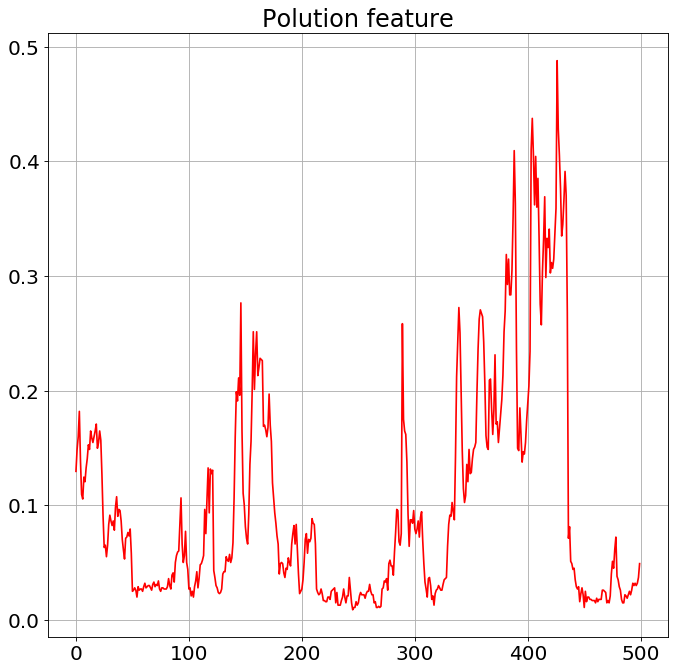

In [3]:
# Plotting polution feature
M = 500
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(dataset[:M, 0], 'r-', label = 'Pollution')
plt.title("Polution feature")
plt.grid('on')

In [4]:
# Splitting dataset
Num_train_percentage = 0.9
Num_train = int(0.9*Num_data)

train = dataset[:Num_train,:]
test = dataset[Num_train:,:]

print(f"Train data shape = {train.shape}")
print(f"Test data shape = {test.shape}")

Train data shape = (39419, 8)
Test data shape = (4380, 8)


In [5]:
# Creating dataset based on window
def createDataset(dataset, window=1, smpl=1, stride=1, predicting_feature=0):
    dataX, dataY = [], []
    N, N_feature = dataset.shape
    Num = int(np.floor((N - window*smpl - 1)/stride))
    index = np.arange(window) * smpl
    
    if Num <= 0:
        print("There is no enough data!")
        return 0, 0
    
    for i in range(Num):
        a = dataset[index, :]
        dataX.append(a)
        dataY.append(dataset[i*stride + window*smpl, predicting_feature])
        index += stride
        
    return np.array(dataX), np.array(dataY)

In [6]:
# Creating datasets based on window size to feed the network
window = 11
trainX, trainY = createDataset(train, window)
testX, testY = createDataset(test, window)
print(f"trainX shape = {trainX.shape} trainY shape = {trainY.shape}")
print(f"testX shape = {testX.shape} testY shape = {testY.shape}")

trainX shape = (39407, 11, 8) trainY shape = (39407,)
testX shape = (4368, 11, 8) testY shape = (4368,)


# Part 1) Building Neural Network:

### 1 & 2) Comparing RNN, LSTM and GRU Recurrent Layers

In [77]:
Results = [0, 0, 0]
Measured_times = [0, 0, 0]
test_evaluation = [0, 0, 0]

In [86]:
T0 = time.time()
# create and fit the network

# We use history to plot loss and accuracy
history = History()

# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 0

# chooseOptimizer: (0 ==> adam) (1 ==> adagard)
chooseOptimizer = 0

# Flag if we want to use Dropout Layers
drop_use = False

# Rate used in Dropout layers
Rate = 0.2

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# Number of fully connected layers
L = 1
N_neurons = 100

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_squared_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "adagard"

# Initializing model as Sequential
model = Sequential()

# Adding Recurrent layer
if Recurrent_Layer == 0:
    model.add(SimpleRNN(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 1:
    model.add(LSTM(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 2:
    model.add(GRU(units, input_shape=(window, Num_features)))
    
# Adding Dropout Layer
if drop_use == True:
    model.add(Dropout(rate = Rate))
    
# Adding fully connected layers
for i in range(L):
    model.add(Dense(N_neurons, activation = "relu"))
    
    # Adding Dropout Layer
    if drop_use == True:
        model.add(Dropout(rate = Rate))
    
# Adding output layer
model.add(Dense(1))

model.compile(loss = Loss, optimizer = Optimizer, metrics = ['mean_squared_error', 'mean_absolute_error'])

model.fit(trainX, trainY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

Results[Recurrent_Layer] = history.history
Measured_times[Recurrent_Layer] = [time.time() - T0]
test_evaluation[Recurrent_Layer] = model.evaluate(testX, testY)

Train on 35466 samples, validate on 3941 samples
Epoch 1/25
35466/35466 [==============================] - 9s 244us/sample - loss: 0.0012 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0198 - val_loss: 6.8823e-04 - val_mean_squared_error: 6.8823e-04 - val_mean_absolute_error: 0.0150
Epoch 2/25
35466/35466 [==============================] - 7s 185us/sample - loss: 8.3996e-04 - mean_squared_error: 8.3996e-04 - mean_absolute_error: 0.0162 - val_loss: 7.6639e-04 - val_mean_squared_error: 7.6639e-04 - val_mean_absolute_error: 0.0178
Epoch 3/25
35466/35466 [==============================] - 7s 186us/sample - loss: 8.2088e-04 - mean_squared_error: 8.2088e-04 - mean_absolute_error: 0.0158 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0242
Epoch 4/25
35466/35466 [==============================] - 6s 180us/sample - loss: 8.1456e-04 - mean_squared_error: 8.1456e-04 - mean_absolute_error: 0.0157 - val_loss: 6.1837e-04 - val_mean_squared_error: 6.1837e-04 -

In [88]:
print("RNN layer:")
print(f"Time taken = {Measured_times[0]} seconds")
print(f"Test evaluation:")
print(f"MSE={test_evaluation[0][0]}, MAE={test_evaluation[0][1]}")
print('\n')

print("LSTM layer:")
print(f"Time taken = {Measured_times[1]} seconds")
print(f"Test evaluation:")
print(f"MSE={test_evaluation[1][0]}, MAE={test_evaluation[1][1]}")
print('\n')


print("GRU layer:")
print(f"Time taken = {Measured_times[2]} seconds")
print(f"Test evaluation:")
print(f"MSE={test_evaluation[2][0]}, MAE={test_evaluation[2][1]}")

RNN layer:
Time taken = [102.5763590335846] seconds
Test evaluation:
MSE=0.0004968974855208737, MAE=0.0004968975554220378


LSTM layer:
Time taken = [195.58380937576294] seconds
Test evaluation:
MSE=0.0005318282384252645, MAE=0.0005318281473591924


GRU layer:
Time taken = [180.7485213279724] seconds
Test evaluation:
MSE=0.0004998963947630497, MAE=0.0004998964723199606


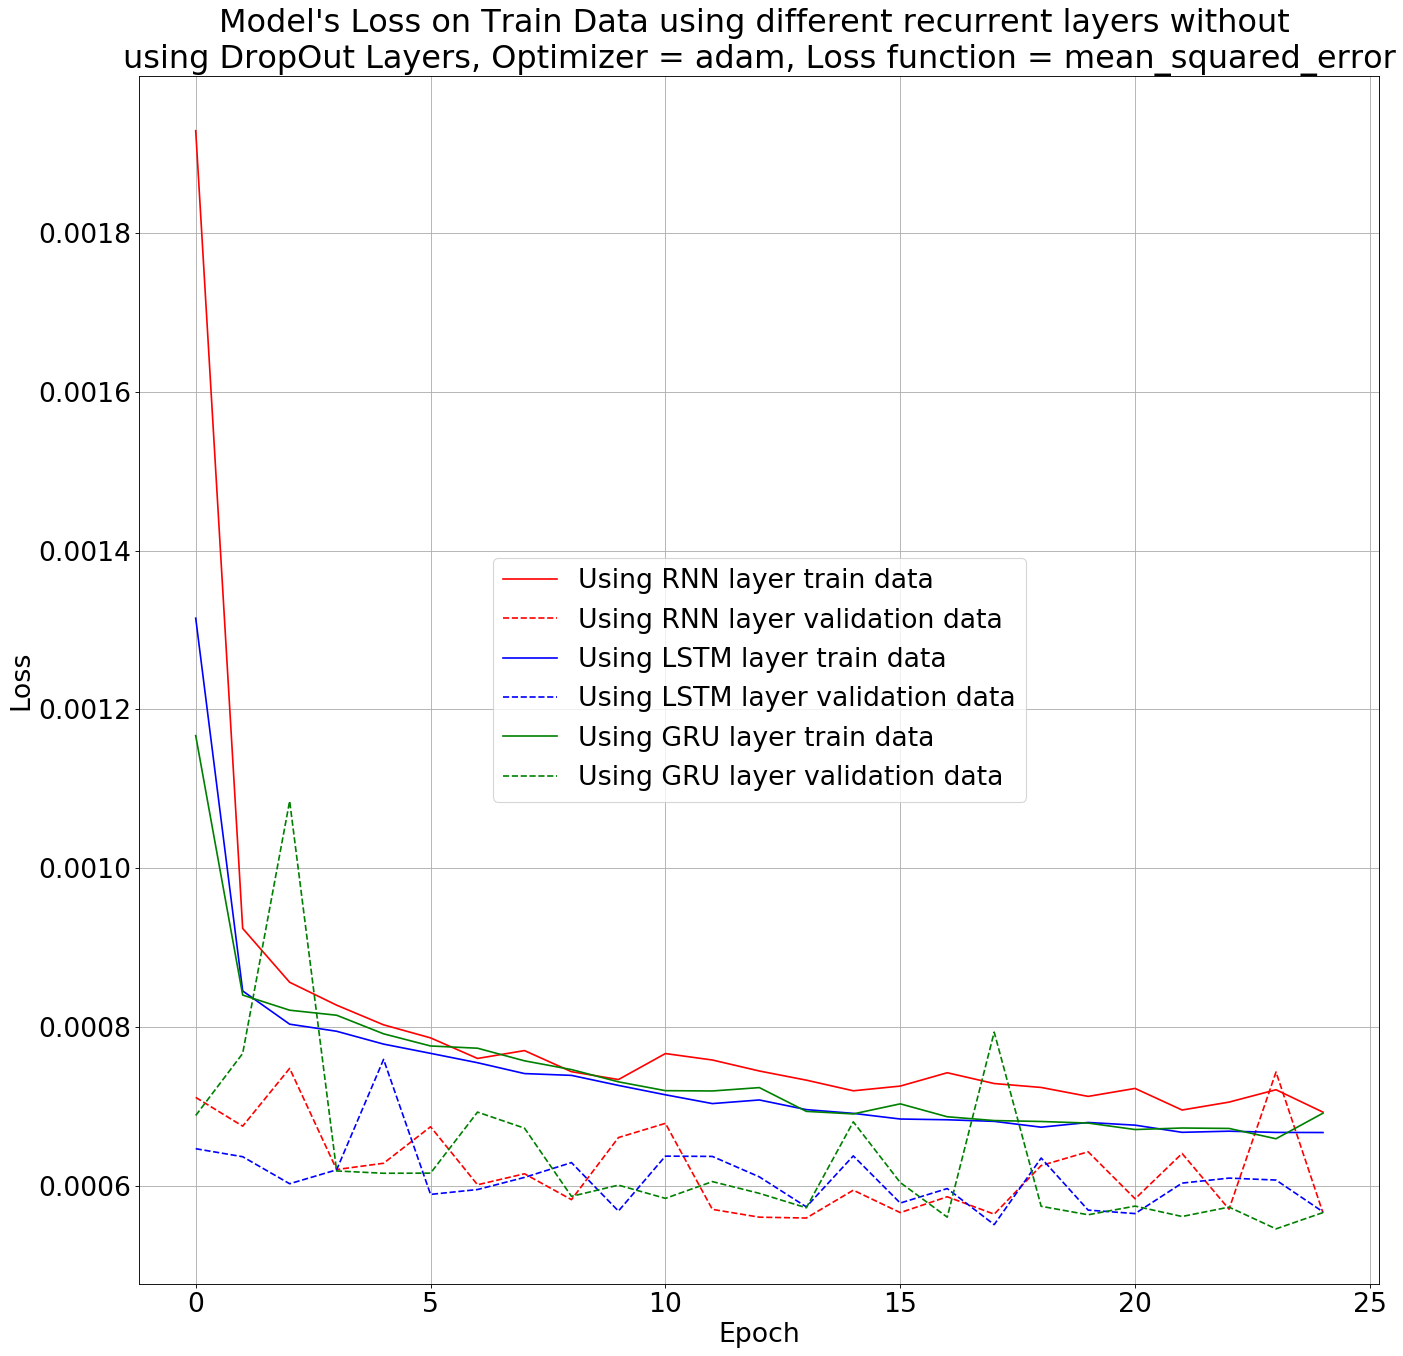

In [89]:
# Plotting Loss values
if drop_use == True:
    DROPUSE = "\nusing DropOut Layers"
else:
    DROPUSE = "without \nusing DropOut Layers"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(Results[0]['loss'], 'r-', label = 'Using RNN layer train data')
plt.plot(Results[0]['val_loss'], 'r--', label = 'Using RNN layer validation data')
plt.plot(Results[1]['loss'], 'b-', label = 'Using LSTM layer train data')
plt.plot(Results[1]['val_loss'], 'b--', label = 'Using LSTM layer validation data')
plt.plot(Results[2]['loss'], 'g-', label = 'Using GRU layer train data')
plt.plot(Results[2]['val_loss'], 'g--', label = 'Using GRU layer validation data')
plt.title(f"Model's Loss on Train Data using different recurrent layers {DROPUSE}, Optimizer = {Optimizer}, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="center")
plt.show()

In [90]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

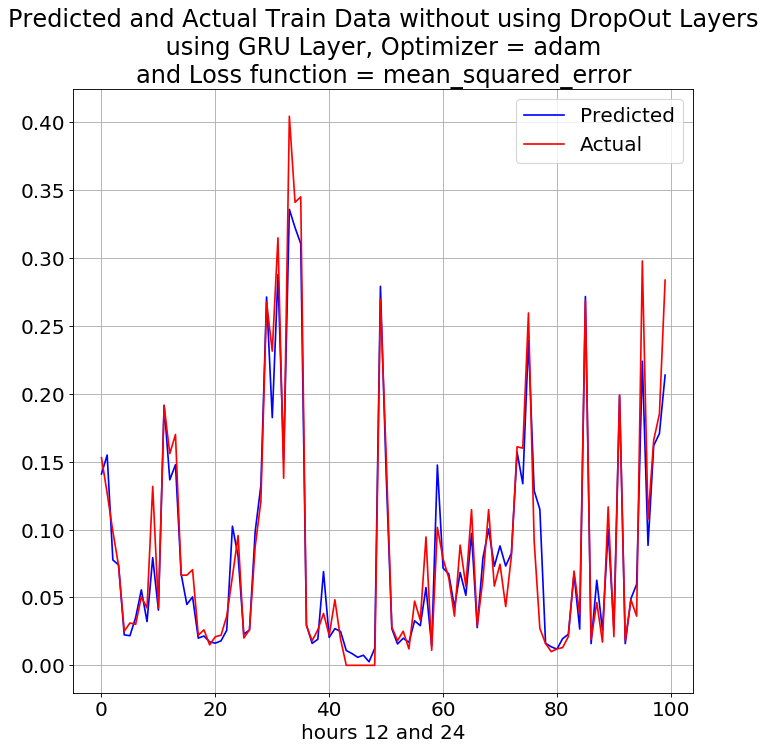

In [91]:
# Train
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"
    
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(trainY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Train Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

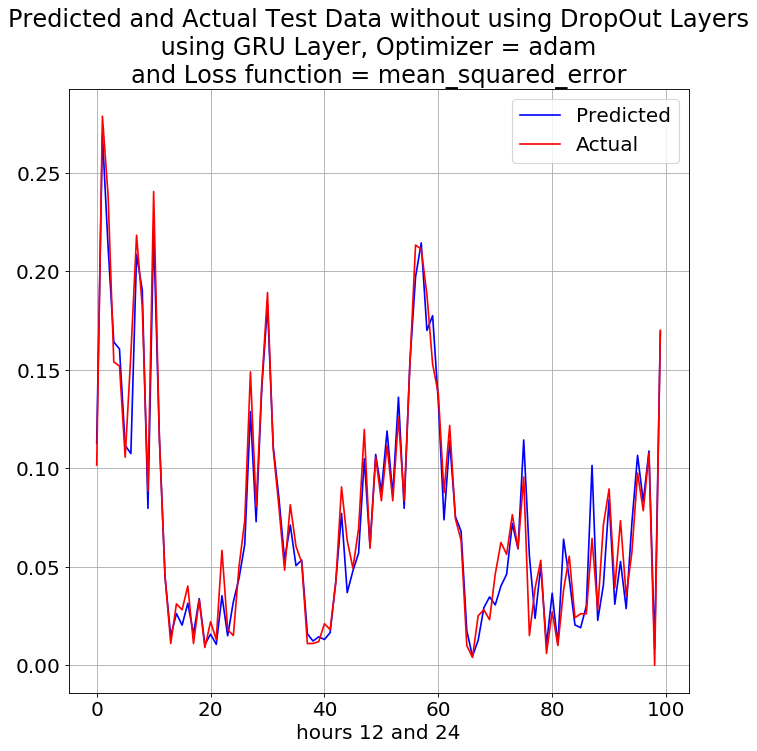

In [92]:
# Test
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"
    
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
M = 200
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(testY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Test Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

### 3) Network's performance with different optimizers and loss functions

First we analyze different optimizers (adam, RMSprop, adagrad). so we fix epochs = 25 and MSE as the loss function

In [95]:
Results_opt = [0, 0, 0]
Measured_times_opt = [0, 0, 0]
Test_opt = [0, 0, 0]

In [106]:
T0 = time.time()
# create and fit the network

# We use history to plot loss and accuracy
history = History()

# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 0

# chooseOptimizer: (0 ==> adam) (1 ==> adagard) (2 ==> rmsprop)
chooseOptimizer = 2

# Flag if we want to use Dropout Layers
drop_use = False

# Rate used in Dropout layers
Rate = 0.2

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# Number of fully connected layers
L = 1
N_neurons = 100

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_absolute_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "Adagrad"
elif chooseOptimizer == 2:
    Optimizer = "RMSprop"

# Initializing model as Sequential
model = Sequential()

# Adding Recurrent layer
if Recurrent_Layer == 0:
    model.add(SimpleRNN(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 1:
    model.add(LSTM(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 2:
    model.add(GRU(units, input_shape=(window, Num_features)))
    
# Adding Dropout Layer
if drop_use == True:
    model.add(Dropout(rate = Rate))
    
# Adding fully connected layers
for i in range(L):
    model.add(Dense(N_neurons, activation = "relu"))
    
    # Adding Dropout Layer
    if drop_use == True:
        model.add(Dropout(rate = Rate))
    
# Adding output layer
model.add(Dense(1))

model.compile(loss = Loss, optimizer = Optimizer, metrics = ['mean_squared_error', 'mean_absolute_error'])

model.fit(trainX, trainY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

Results_opt[chooseOptimizer] = history.history
Measured_times_opt[chooseOptimizer] = time.time() - T0
Test_opt[chooseOptimizer] = model.evaluate(testX, testY)

Train on 35466 samples, validate on 3941 samples
Epoch 1/25
35466/35466 [==============================] - 8s 237us/sample - loss: 0.0015 - mean_squared_error: 0.0015 - mean_absolute_error: 0.0247 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_mean_absolute_error: 0.0231
Epoch 2/25
35466/35466 [==============================] - 7s 200us/sample - loss: 9.1084e-04 - mean_squared_error: 9.1084e-04 - mean_absolute_error: 0.0175 - val_loss: 7.4058e-04 - val_mean_squared_error: 7.4058e-04 - val_mean_absolute_error: 0.0164
Epoch 3/25
35466/35466 [==============================] - 7s 194us/sample - loss: 8.5272e-04 - mean_squared_error: 8.5272e-04 - mean_absolute_error: 0.0165 - val_loss: 8.5007e-04 - val_mean_squared_error: 8.5007e-04 - val_mean_absolute_error: 0.0188
Epoch 4/25
35466/35466 [==============================] - 6s 180us/sample - loss: 8.0986e-04 - mean_squared_error: 8.0986e-04 - mean_absolute_error: 0.0158 - val_loss: 6.5313e-04 - val_mean_squared_error: 6.5313e-04 -

In [107]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

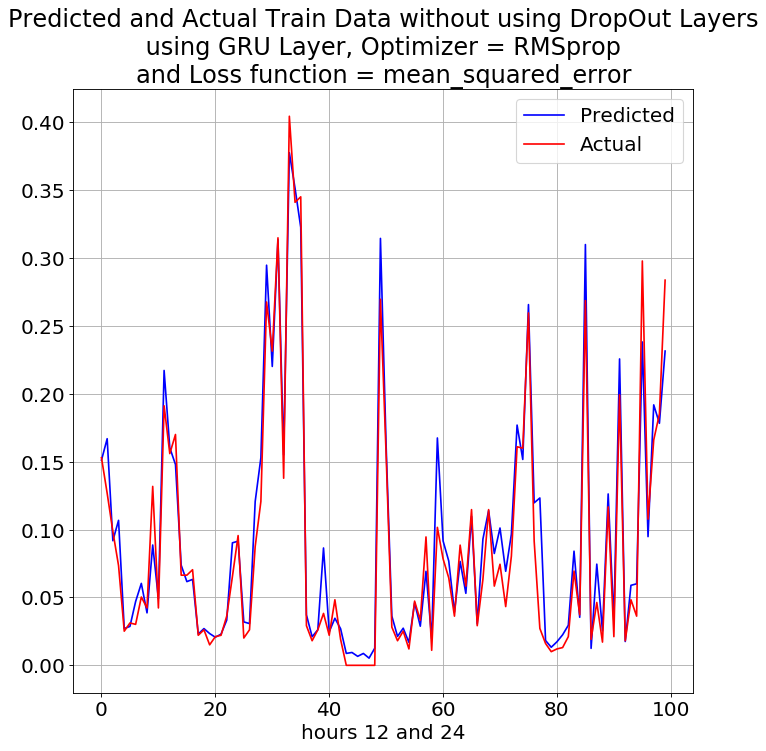

In [108]:
# Train
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"
    
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(trainY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Train Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

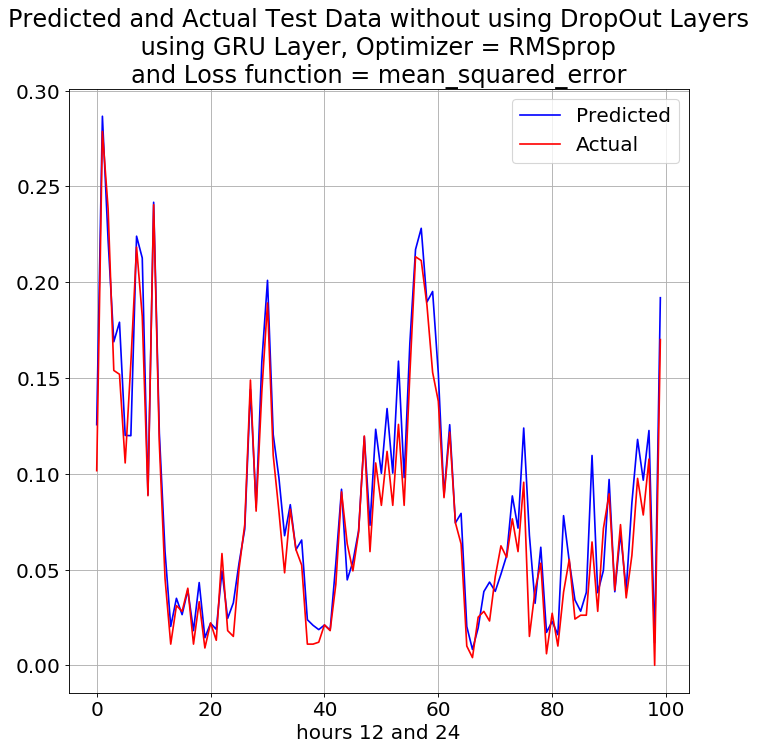

In [109]:
# Test
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"
    
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(testY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Test Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

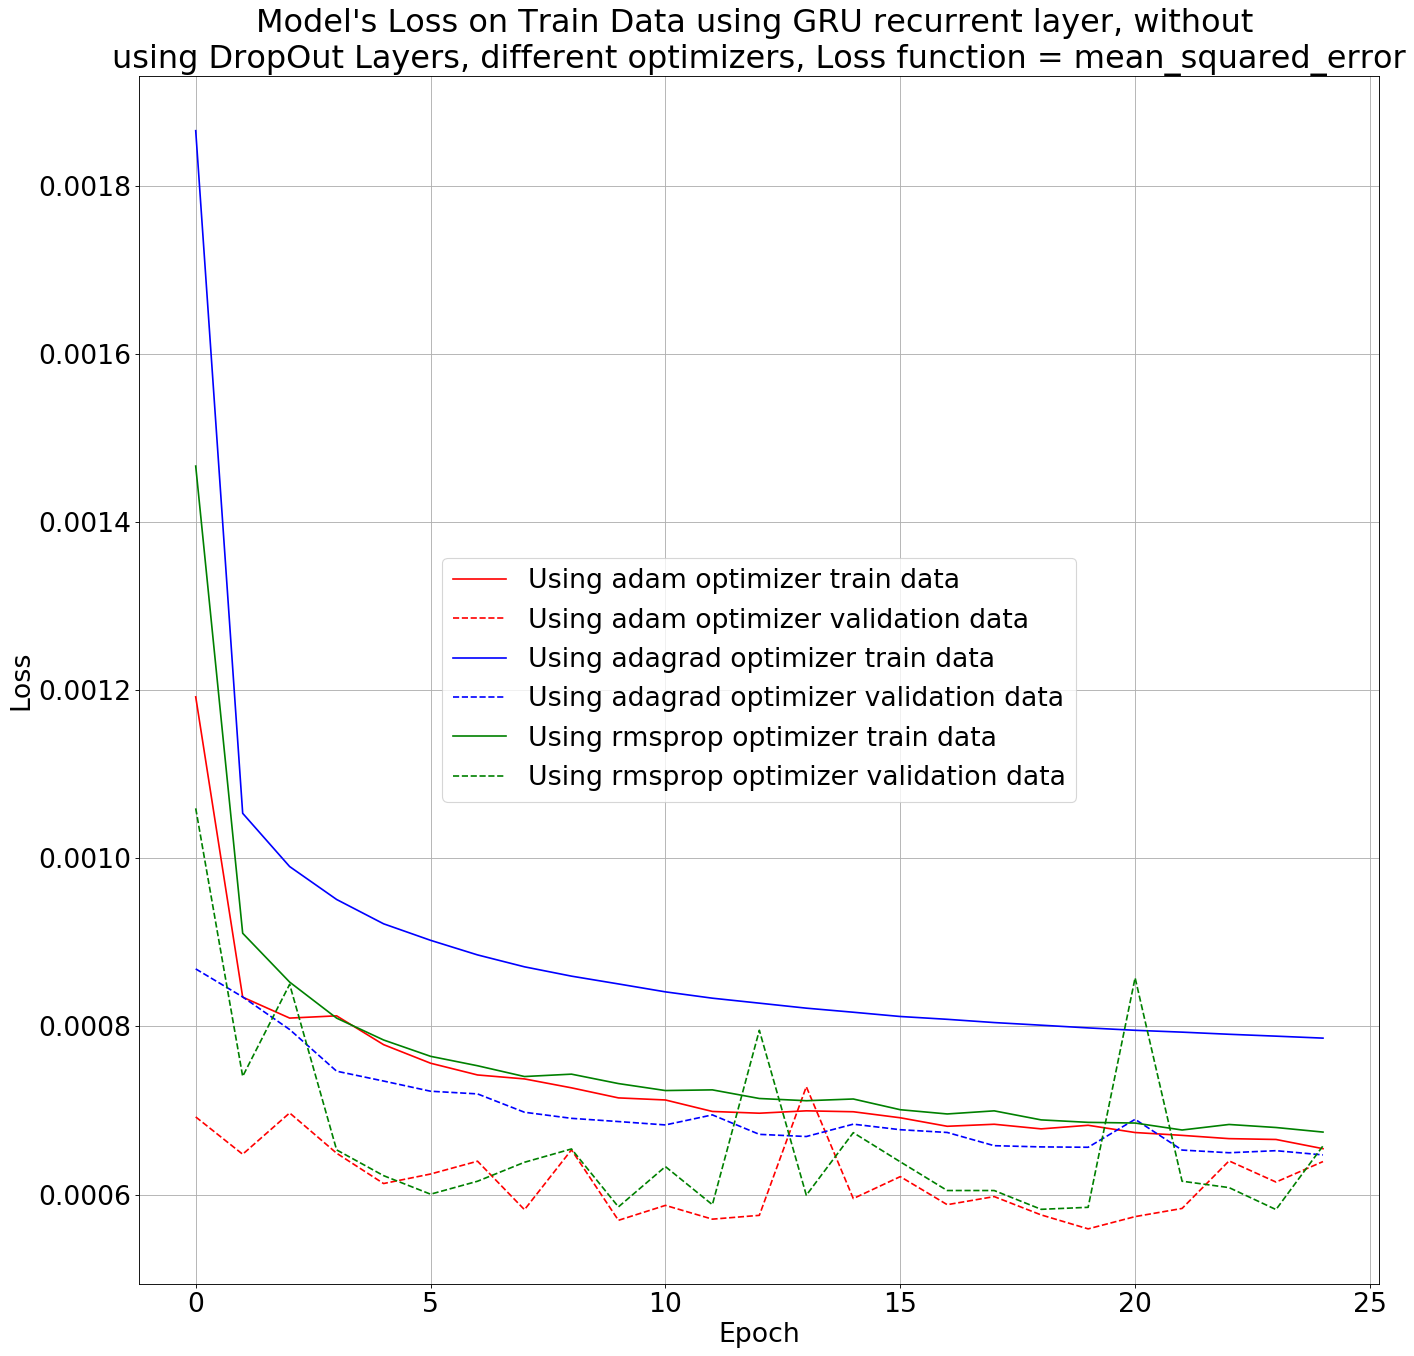

In [112]:
# Plotting Loss values
if drop_use == True:
    DROPUSE = "\nusing DropOut Layers"
else:
    DROPUSE = "without \nusing DropOut Layers"
    
if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(Results_opt[0]['loss'], 'r-', label = 'Using adam optimizer train data')
plt.plot(Results_opt[0]['val_loss'], 'r--', label = 'Using adam optimizer validation data')
plt.plot(Results_opt[1]['loss'], 'b-', label = 'Using adagrad optimizer train data')
plt.plot(Results_opt[1]['val_loss'], 'b--', label = 'Using adagrad optimizer validation data')
plt.plot(Results_opt[2]['loss'], 'g-', label = 'Using rmsprop optimizer train data')
plt.plot(Results_opt[2]['val_loss'], 'g--', label = 'Using rmsprop optimizer validation data')
plt.title(f"Model's Loss on Train Data using {RECURRENT} recurrent layer, {DROPUSE}, different optimizers, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="center")
plt.show()

In [118]:
print(f"{RECURRENT} layer results:\n")
print("Adam optimizer:")
print(f"Time taken = {Measured_times_opt[0]} seconds")
print(f"Test evaluation:")
print(f"MSE = {Test_opt[0][0]}, MAE = {Test_opt[0][1]}")
print('\n')

print("Adagrad optimizer:")
print(f"Time taken = {Measured_times_opt[1]} seconds")
print(f"Test evaluation:")
print(f"MSE = {Test_opt[1][0]}, MAE = {Test_opt[1][1]}")
print('\n')

print("RMSprop optimizer:")
print(f"Time taken = {Measured_times_opt[2]} seconds")
print(f"Test evaluation:")
print(f"MSE = {Test_opt[2][0]}, MAE = {Test_opt[2][1]}")

GRU layer results:

Adam optimizer:
Time taken = 164.44748759269714 seconds
Test evaluation:
MSE = 0.0005907816742035141, MAE = 0.000590781681239605


Adagrad optimizer:
Time taken = 174.2288691997528 seconds
Test evaluation:
MSE = 0.0005181977082659384, MAE = 0.0005181977176107466


RMSprop optimizer:
Time taken = 164.38564944267273 seconds
Test evaluation:
MSE = 0.0005775487009157007, MAE = 0.0005775486933998764


## Now we analyze different loss functions (MSE, MAE). so we fix epochs = 25 and MSE as the loss function

In [131]:
Results_loss = [0, 0]
Measured_times_loss = [0, 0]
Test_loss = [0, 0]

In [138]:
T0 = time.time()
# create and fit the network

# We use history to plot loss and accuracy
history = History()

# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 1

# chooseOptimizer: (0 ==> adam) (1 ==> adagard) (2 ==> rmsprop)
chooseOptimizer = 0

# Flag if we want to use Dropout Layers
drop_use = False

# Rate used in Dropout layers
Rate = 0.2

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# Number of fully connected layers
L = 1
N_neurons = 100

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_absolute_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "Adagrad"
elif chooseOptimizer == 2:
    Optimizer = "RMSprop"

# Initializing model as Sequential
model = Sequential()

# Adding Recurrent layer
if Recurrent_Layer == 0:
    model.add(SimpleRNN(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 1:
    model.add(LSTM(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 2:
    model.add(GRU(units, input_shape=(window, Num_features)))
    
# Adding Dropout Layer
if drop_use == True:
    model.add(Dropout(rate = Rate))
    
# Adding fully connected layers
for i in range(L):
    model.add(Dense(N_neurons, activation = "relu"))
    
    # Adding Dropout Layer
    if drop_use == True:
        model.add(Dropout(rate = Rate))
    
# Adding output layer
model.add(Dense(1))

model.compile(loss = Loss, optimizer = Optimizer, metrics = ['mean_squared_error', 'mean_absolute_error'])

model.fit(trainX, trainY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

Results_loss[chooseLoss] = history.history
Measured_times_loss[chooseLoss] = time.time() - T0
Test_loss[chooseLoss] = model.evaluate(testX, testY)

Train on 35466 samples, validate on 3941 samples
Epoch 1/25
35466/35466 [==============================] - 8s 230us/sample - loss: 0.0176 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0176 - val_loss: 0.0148 - val_mean_squared_error: 6.7875e-04 - val_mean_absolute_error: 0.0148
Epoch 2/25
35466/35466 [==============================] - 6s 178us/sample - loss: 0.0147 - mean_squared_error: 8.0729e-04 - mean_absolute_error: 0.0147 - val_loss: 0.0129 - val_mean_squared_error: 6.2331e-04 - val_mean_absolute_error: 0.0129
Epoch 3/25
35466/35466 [==============================] - 6s 178us/sample - loss: 0.0141 - mean_squared_error: 7.9106e-04 - mean_absolute_error: 0.0141 - val_loss: 0.0133 - val_mean_squared_error: 6.4228e-04 - val_mean_absolute_error: 0.0133
Epoch 4/25
35466/35466 [==============================] - 6s 177us/sample - loss: 0.0140 - mean_squared_error: 7.8537e-04 - mean_absolute_error: 0.0140 - val_loss: 0.0126 - val_mean_squared_error: 6.1937e-04 - val_mean_absolute_e

In [139]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

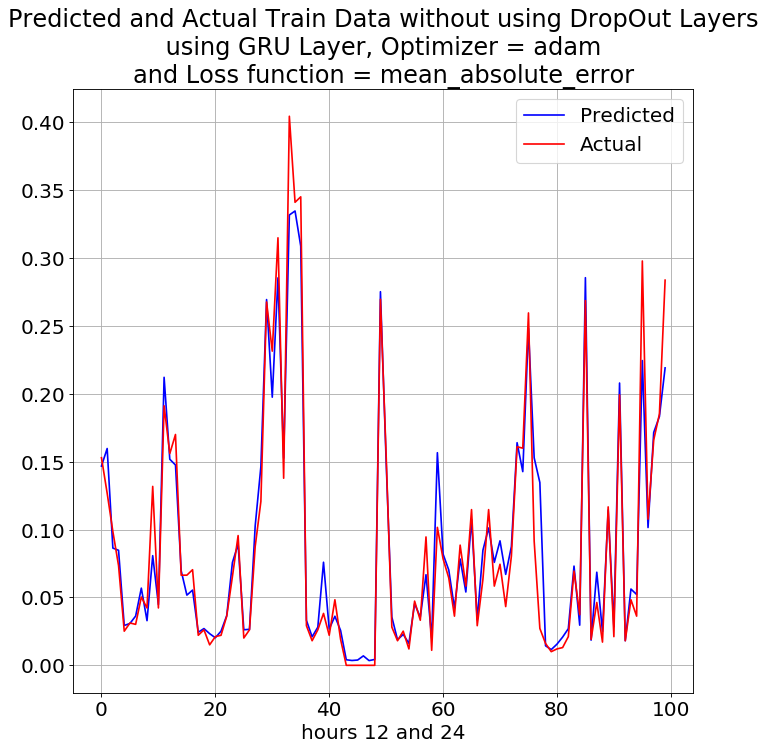

In [140]:
# Train
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"
    
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(trainY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Train Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

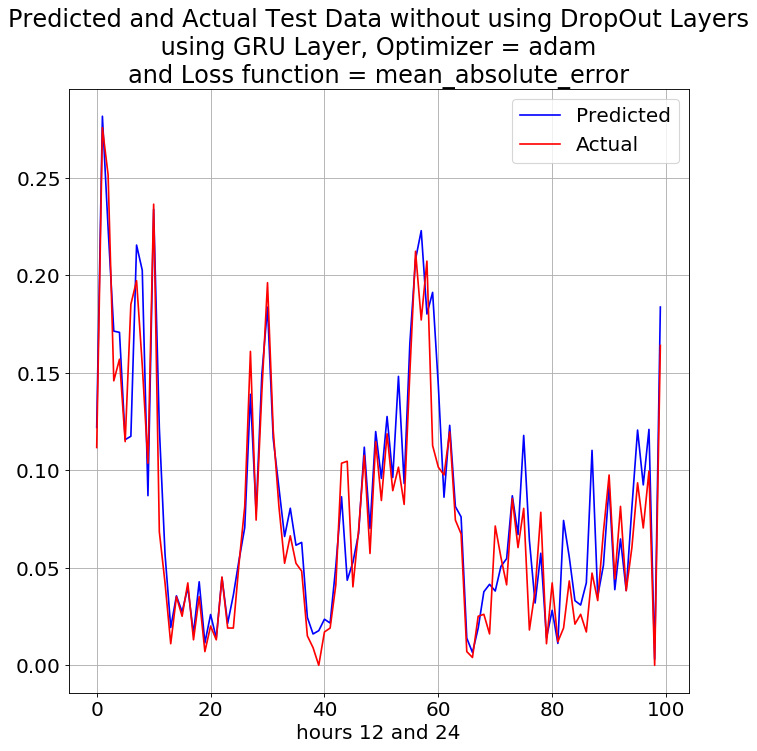

In [141]:
# Test
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"
    
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(testY[plot_range+1], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Test Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

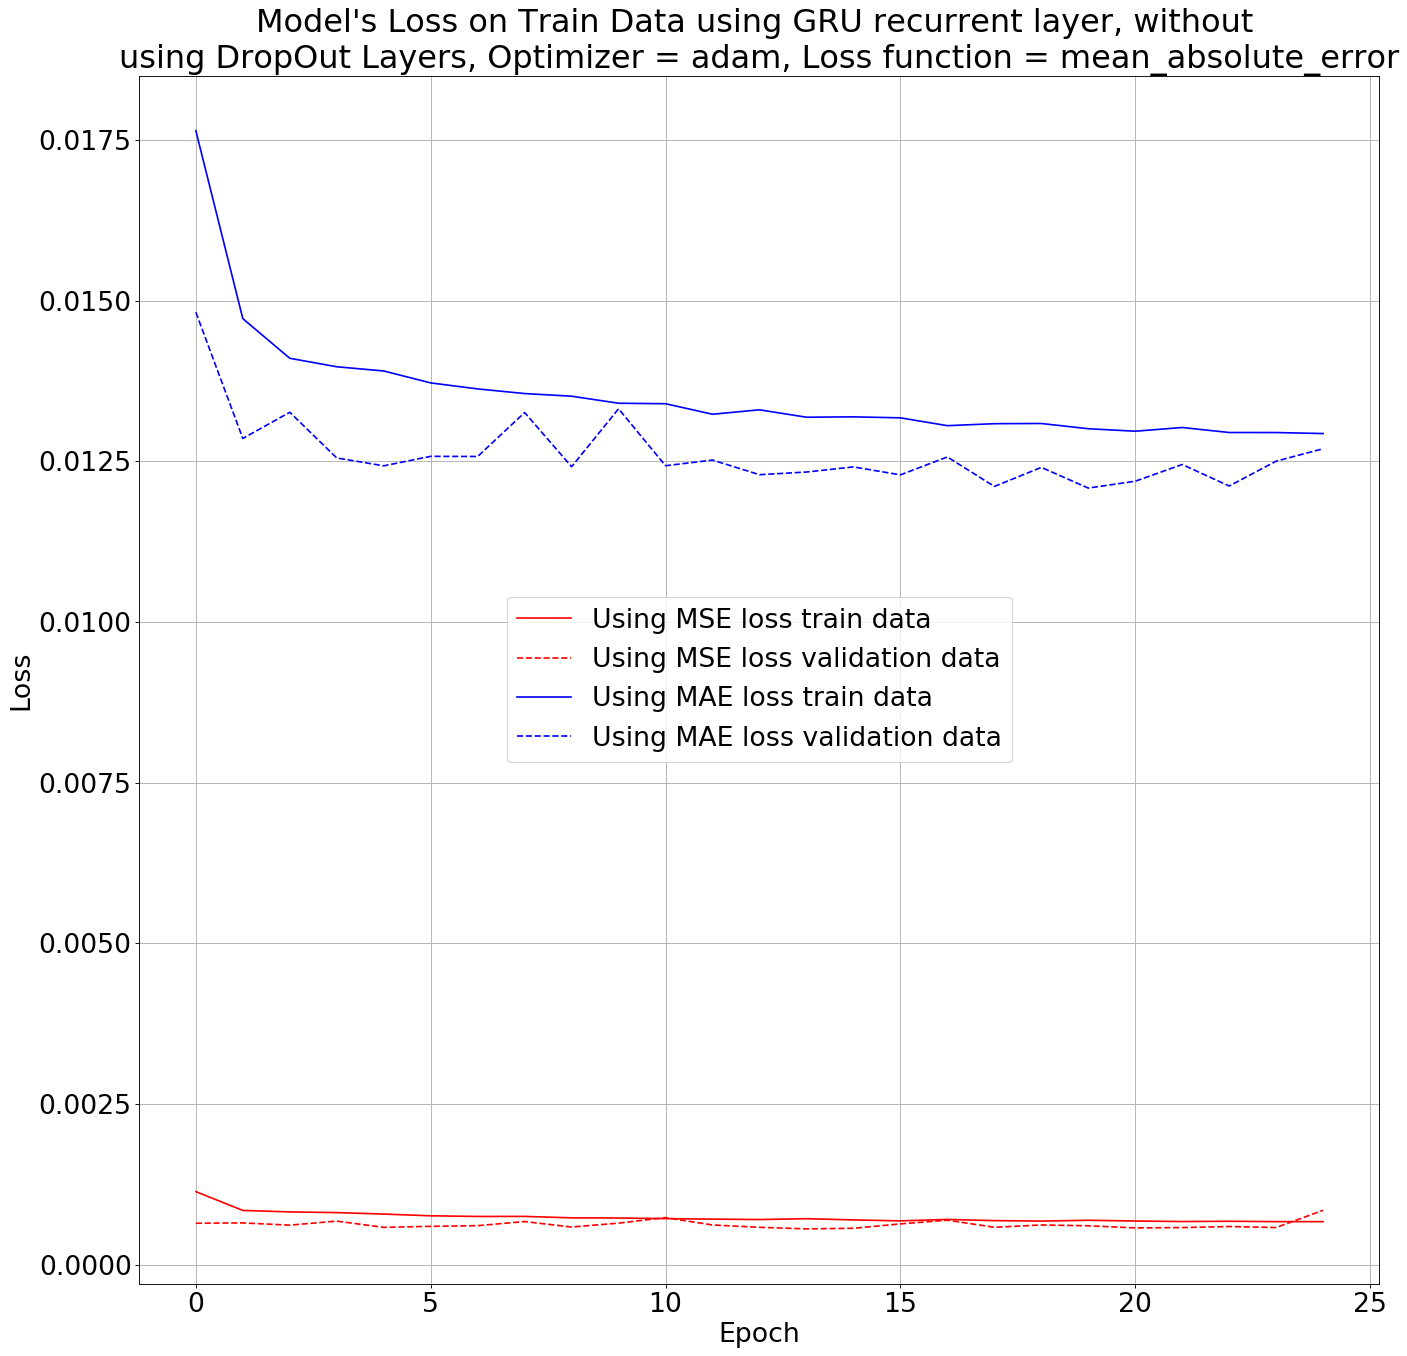

In [143]:
# Plotting Loss values
if drop_use == True:
    DROPUSE = "\nusing DropOut Layers"
else:
    DROPUSE = "without \nusing DropOut Layers"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(Results_loss[0]['loss'], 'r-', label = 'Using MSE loss train data')
plt.plot(Results_loss[0]['val_loss'], 'r--', label = 'Using MSE loss validation data')
plt.plot(Results_loss[1]['loss'], 'b-', label = 'Using MAE loss train data')
plt.plot(Results_loss[1]['val_loss'], 'b--', label = 'Using MAE loss validation data')
plt.title(f"Model's Loss on Train Data using {RECURRENT} recurrent layer, {DROPUSE}, Optimizer = {Optimizer}, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="center")
plt.show()

In [146]:
print(f"{RECURRENT} layer results:\n")
print(f"MSE loss function:")
print(f"Time taken = {Measured_times_loss[0]} seconds")
print("Test evaluation:")
print(f"MSE = {Test_loss[0][0]}, MAE = {Test_loss[0][1]}")
print("\n")

print(f"MAE loss function:")
print(f"Time taken = {Measured_times_loss[1]} seconds")
print("Test evaluation:")
print(f"MSE = {Test_loss[1][0]}, MAE = {Test_loss[1][1]}")
print("\n")

GRU layer results:

MSE loss function:
Time taken = 157.4828884601593 seconds
Test evaluation:
MSE = 0.0006619819554204127, MAE = 0.0006619818741455674


MAE loss function:
Time taken = 171.610089302063 seconds
Test evaluation:
MSE = 0.011556239423406866, MAE = 0.0004769784864038229




## Part 4) Different Time Series (weekly and monthly prediction):

In [147]:
# Preparing datasets

# Choosing random hours and day 
randomHourWeek = np.random.randint(24, size = 1)
randomHourMonth = np.random.randint(24, size = 1)
randomDayMonth = np.random.randint(7, size = 1)

stride_week = 1
stride_month = 1

smpl_week = 24
smpl_month = 24 * 7

In [148]:
# Splitting Datasets
percentageWeek = 0.8
percentageMonth = 0.8

N_train_week = int(percentageWeek * Num_data)
N_train_month = int(percentageMonth * Num_data)

window_week = 7
window_month = 4

trainWeek = dataset[:N_train_week, :]
testWeek = dataset[N_train_week:, :]

trainMonth = dataset[:N_train_month, :]
testMonth= dataset[N_train_month:, :]

### Week Prediction:

In [149]:
# Creating datasets based on window size to feed the network
trainWeekX, trainWeekY = createDataset(trainWeek, window=window_week, smpl=smpl_week, stride=stride_week, predicting_feature=0)
testWeekX, testWeekY = createDataset(testWeek, window=window_week, smpl=smpl_week, stride=stride_week, predicting_feature=0)
print(f"trainWeekX shape = {trainWeekX.shape} trainWeekY shape = {trainWeekY.shape}")
print(f"testWeekX shape = {testWeekX.shape} testWeekY shape = {testWeekY.shape}")

trainWeekX shape = (34870, 7, 8) trainWeekY shape = (34870,)
testWeekX shape = (8591, 7, 8) testWeekY shape = (8591,)


In [151]:
T0 = time.time()
# Flag to predict weekly or monthly

# create and fit the network

# We use history to plot loss and accuracy
history = History()

# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 0

# chooseOptimizer: (0 ==> adam) (1 ==> adagard)
chooseOptimizer = 0

# Flag if we want to use Dropout Layers
drop_use = True

# Rate used in Dropout layers
Rate = 0.2

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# Number of fully connected layers
L = 1
N_neurons = 100

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_squared_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "adagard"

# Initializing model as Sequential
model = Sequential()

# Adding Recurrent layer
if Recurrent_Layer == 0:
    model.add(SimpleRNN(units, input_shape=(window_week, Num_features)))
elif Recurrent_Layer == 1:
    model.add(LSTM(units, input_shape=(window_week, Num_features)))
elif Recurrent_Layer == 2:
    model.add(GRU(units, input_shape=(window_week, Num_features)))
    
# Adding Dropout Layer
if drop_use == True:
    model.add(Dropout(rate = Rate))
    
# Adding fully connected layers
for i in range(L):
    model.add(Dense(N_neurons, activation = "relu"))
    
    # Adding Dropout Layer
    if drop_use == True:
        model.add(Dropout(rate = Rate))
    
# Adding output layer
model.add(Dense(1))

model.compile(loss = Loss, optimizer = Optimizer)

model.fit(trainWeekX, trainWeekY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

Result = history.history
Time_taken = time.time() - T0

Train on 31383 samples, validate on 3487 samples
Epoch 1/25
31383/31383 [==============================] - 6s 201us/sample - loss: 0.0079 - val_loss: 0.0067
Epoch 2/25
31383/31383 [==============================] - 5s 157us/sample - loss: 0.0073 - val_loss: 0.0069
Epoch 3/25
31383/31383 [==============================] - 5s 146us/sample - loss: 0.0072 - val_loss: 0.0065
Epoch 4/25
31383/31383 [==============================] - 4s 137us/sample - loss: 0.0071 - val_loss: 0.0065
Epoch 5/25
31383/31383 [==============================] - 5s 149us/sample - loss: 0.0070 - val_loss: 0.0066
Epoch 6/25
31383/31383 [==============================] - 4s 141us/sample - loss: 0.0070 - val_loss: 0.0067
Epoch 7/25
31383/31383 [==============================] - 4s 135us/sample - loss: 0.0069 - val_loss: 0.0067
Epoch 8/25
31383/31383 [==============================] - 4s 136us/sample - loss: 0.0069 - val_loss: 0.0067
Epoch 9/25
31383/31383 [==============================] - 4s 138us/sample - loss: 0.006

In [152]:
model.evaluate(testWeekX, testWeekY)

8591/8591 [==============================] - 0s 45us/sample - loss: 0.0083


0.00832090113046843

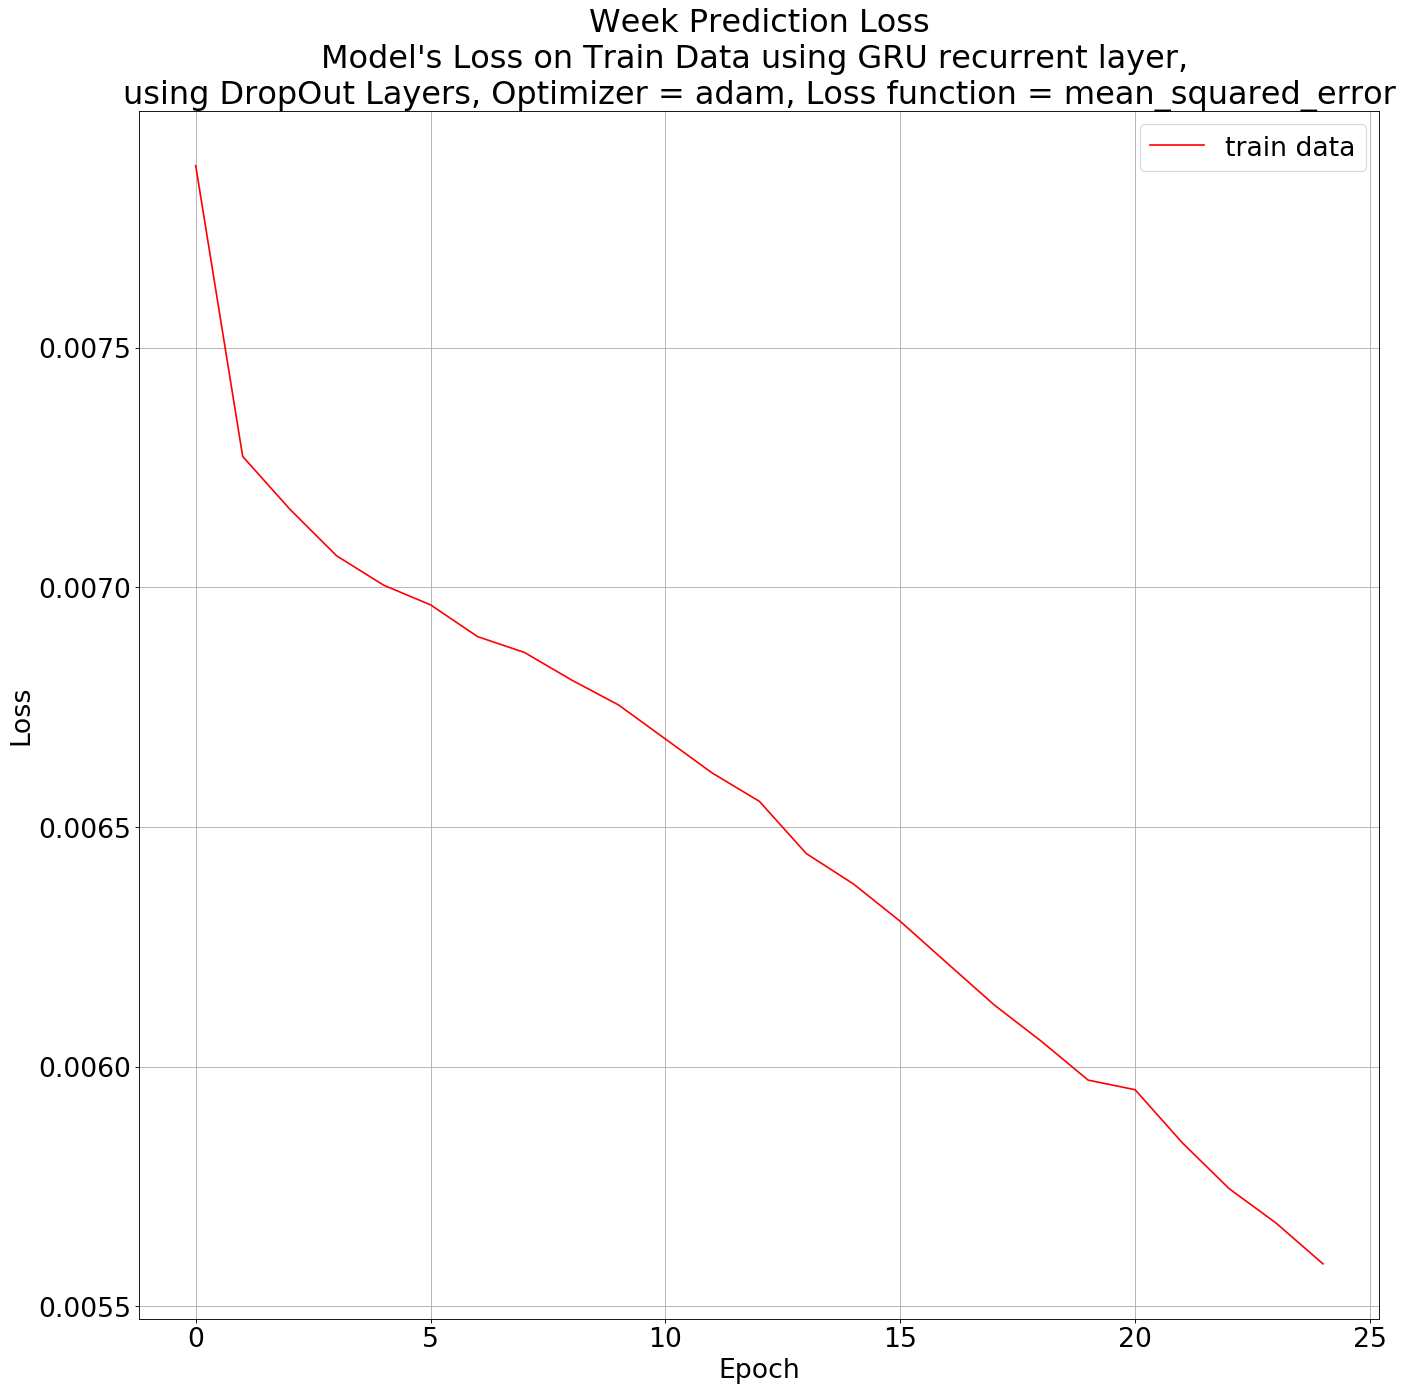

In [155]:
# Plotting Loss values
if drop_use == True:
    DROPUSE = "\nusing DropOut Layers"
else:
    DROPUSE = "without \nusing DropOut Layers"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(Result['loss'], 'r-', label = 'train data')
#plt.plot(Result['val_loss'], 'b--', label = 'validation data')
plt.title(f"Week Prediction Loss\nModel's Loss on Train Data using GRU recurrent layer, {DROPUSE}, Optimizer = {Optimizer}, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="upper right")
plt.show()

In [158]:
# make predictions
trainPredictWeek = model.predict(trainWeekX)
testPredictWeek = model.predict(testWeekX)

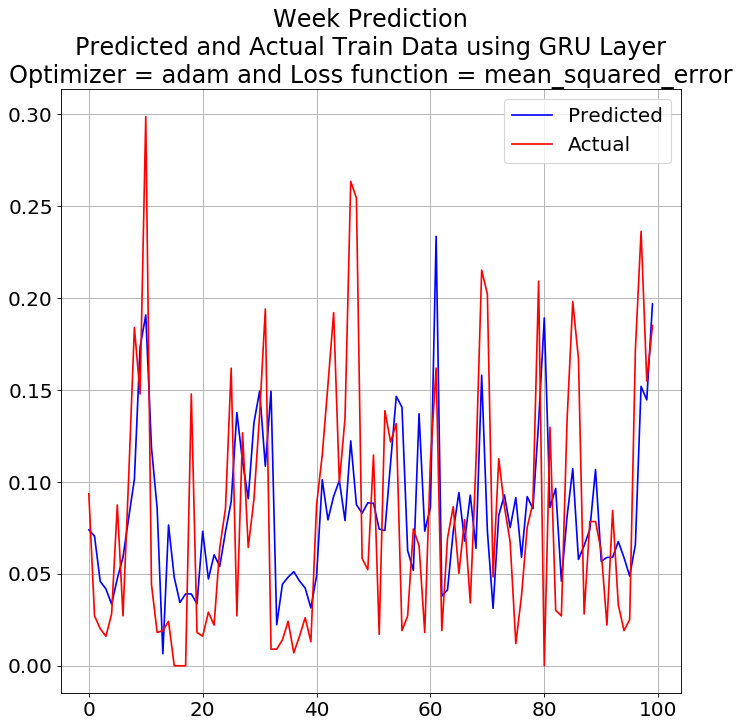

In [160]:
# Train
M = 100

index_plot_train_week = 24*np.arange(M) + randomHourWeek

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredictWeek[index_plot_train_week, 0], 'b-', label = 'Predicted')
plt.plot(trainWeek[index_plot_train_week + 24*window_week, 0], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Week Prediction\nPredicted and Actual Train Data using {RECURRENT} Layer\nOptimizer = {Optimizer} and Loss function = {Loss}")
plt.legend(loc="upper right")

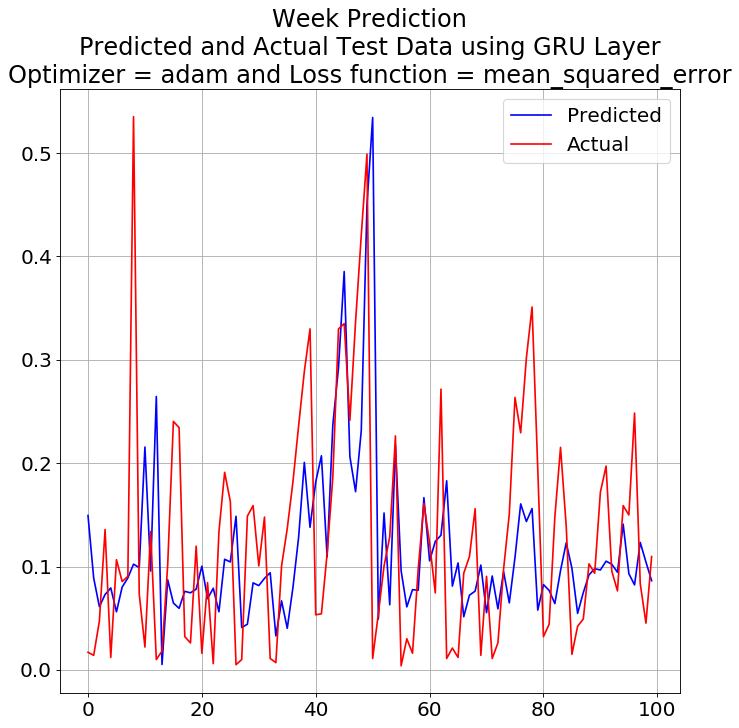

In [161]:
# Test
M = 100

index_plot_test_week = 24*np.arange(M) + randomHourWeek

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredictWeek[index_plot_test_week, 0], 'b-', label = 'Predicted')
plt.plot(testWeek[index_plot_test_week + 24*window_week, 0], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Week Prediction\nPredicted and Actual Test Data using {RECURRENT} Layer\nOptimizer = {Optimizer} and Loss function = {Loss}")
plt.legend(loc="upper right")

### Month Prediction:

In [162]:
# Creating datasets based on window size to feed the network
trainMonthX, trainMonthY = createDataset(trainMonth, window=window_month, smpl=smpl_month, stride=stride_month, predicting_feature=0)
testMonthX, testMonthY = createDataset(trainMonth, window=window_month, smpl=smpl_month, stride=stride_month, predicting_feature=0)
print(f"trainMonthX shape = {trainMonthX.shape} trainWeekY shape = {trainMonthY.shape}")
print(f"testMonthX shape = {testMonthX.shape} testMonthY shape = {testMonthY.shape}")

trainMonthX shape = (34366, 4, 8) trainWeekY shape = (34366,)
testMonthX shape = (34366, 4, 8) testMonthY shape = (34366,)


In [163]:
T0 = time.time()
# Flag to predict weekly or monthly

# create and fit the network

# We use history to plot loss and accuracy
history = History()

# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 0

# chooseOptimizer: (0 ==> adam) (1 ==> adagard)
chooseOptimizer = 0

# Flag if we want to use Dropout Layers
drop_use = False

# Rate used in Dropout layers
Rate = 0.2

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# Number of fully connected layers
L = 1
N_neurons = 100

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_squared_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "adagard"

# Initializing model as Sequential
model = Sequential()

# Adding Recurrent layer
if Recurrent_Layer == 0:
    model.add(SimpleRNN(units, input_shape=(window_month, Num_features)))
elif Recurrent_Layer == 1:
    model.add(LSTM(units, input_shape=(window_month, Num_features)))
elif Recurrent_Layer == 2:
    model.add(GRU(units, input_shape=(window_month, Num_features)))
    
# Adding Dropout Layer
if drop_use == True:
    model.add(Dropout(rate = Rate))
    
# Adding fully connected layers
for i in range(L):
    model.add(Dense(N_neurons, activation = "relu"))
    
    # Adding Dropout Layer
    if drop_use == True:
        model.add(Dropout(rate = Rate))
    
# Adding output layer
model.add(Dense(1))

model.compile(loss = Loss, optimizer = Optimizer)

model.fit(trainMonthX, trainMonthY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

ResultMonth = history.history
Time_taken_Month = time.time() - T0

Train on 30929 samples, validate on 3437 samples
Epoch 1/25
30929/30929 [==============================] - 5s 170us/sample - loss: 0.0087 - val_loss: 0.0075
Epoch 2/25
30929/30929 [==============================] - 4s 114us/sample - loss: 0.0086 - val_loss: 0.0076
Epoch 3/25
30929/30929 [==============================] - 3s 104us/sample - loss: 0.0085 - val_loss: 0.0076
Epoch 4/25
30929/30929 [==============================] - 3s 106us/sample - loss: 0.0084 - val_loss: 0.0076
Epoch 5/25
30929/30929 [==============================] - 3s 104us/sample - loss: 0.0083 - val_loss: 0.0078
Epoch 6/25
30929/30929 [==============================] - 3s 104us/sample - loss: 0.0082 - val_loss: 0.0079
Epoch 7/25
30929/30929 [==============================] - 3s 105us/sample - loss: 0.0080 - val_loss: 0.0080
Epoch 8/25
30929/30929 [==============================] - 3s 103us/sample - loss: 0.0079 - val_loss: 0.0082
Epoch 9/25
30929/30929 [==============================] - 3s 111us/sample - loss: 0.007

In [164]:
model.evaluate(testMonthX, testMonthY)

34366/34366 [==============================] - 1s 35us/sample - loss: 0.0046


0.004557538782522019

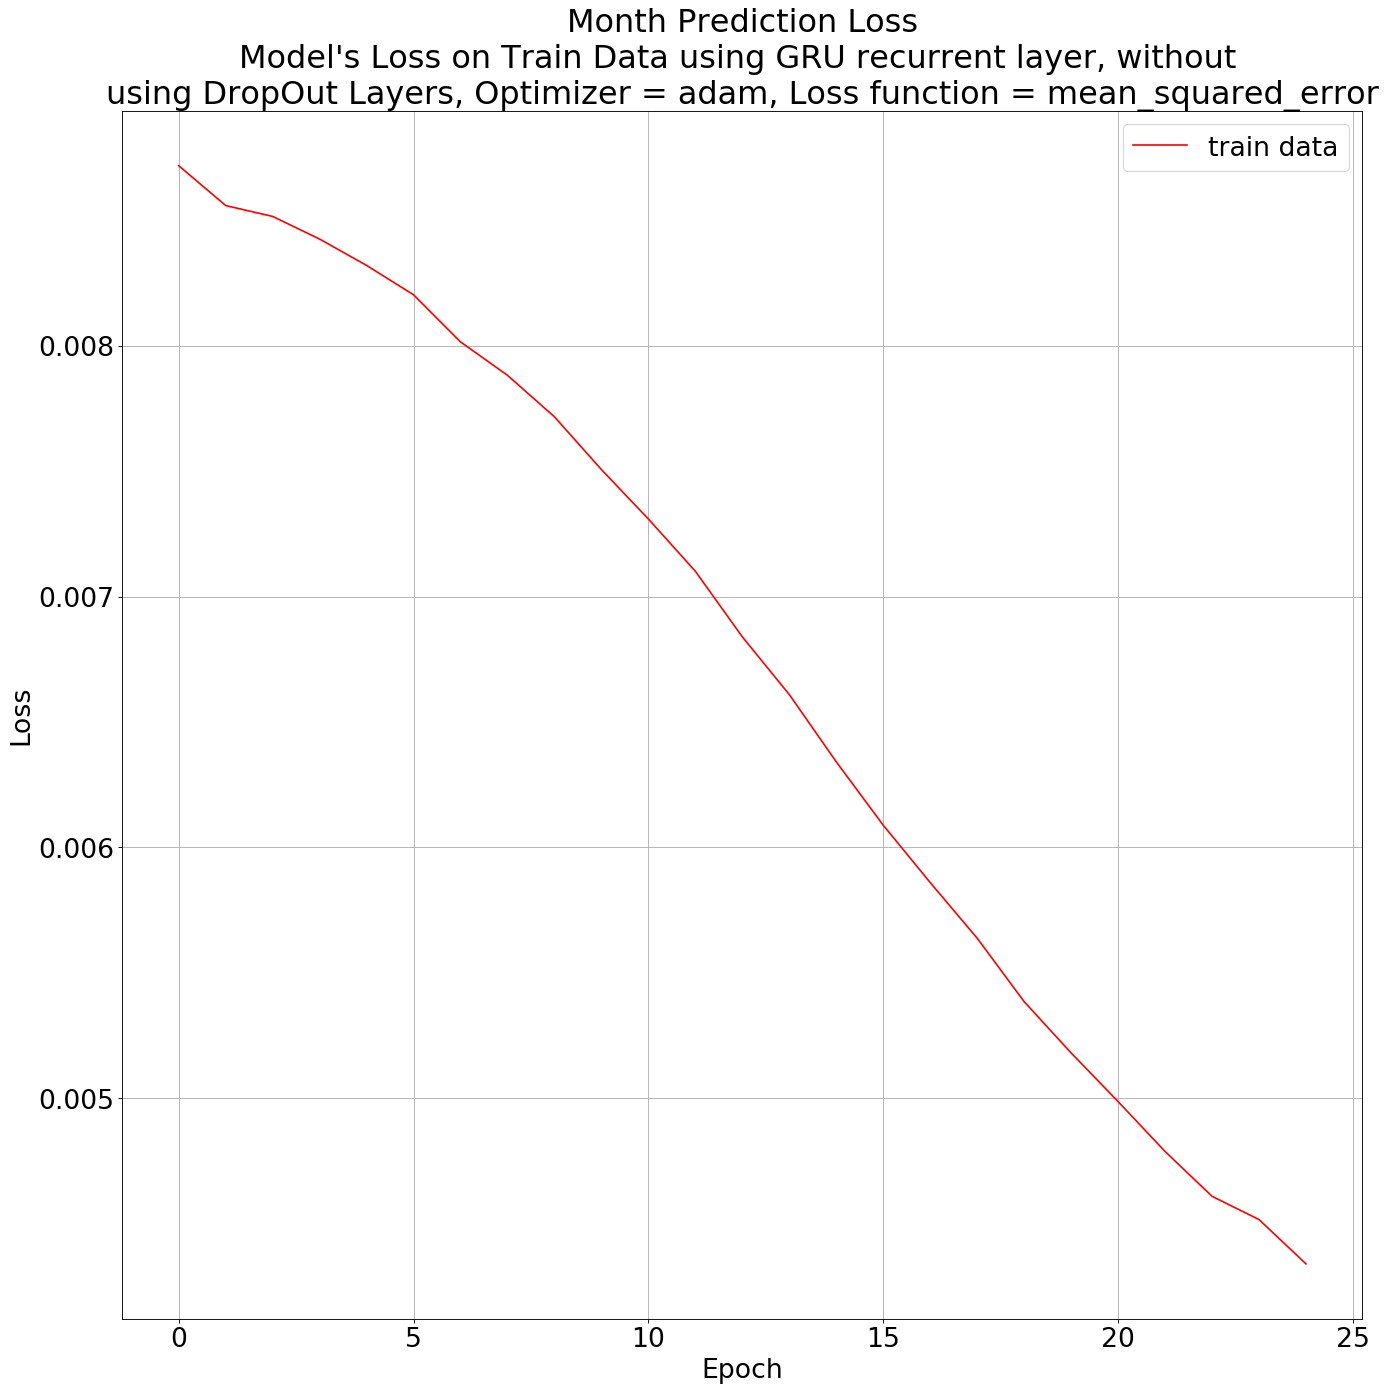

In [165]:
# Plotting Loss values
if drop_use == True:
    DROPUSE = "\nusing DropOut Layers"
else:
    DROPUSE = "without \nusing DropOut Layers"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(ResultMonth['loss'], 'r-', label = 'train data')
#plt.plot(ResultMonth['val_loss'], 'b--', label = 'validation data')
plt.title(f"Month Prediction Loss\nModel's Loss on Train Data using GRU recurrent layer, {DROPUSE}, Optimizer = {Optimizer}, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="upper right")
plt.show()

In [166]:
# make predictions
trainPredictMonth = model.predict(trainMonthX)
testPredictMonth = model.predict(testMonthX)

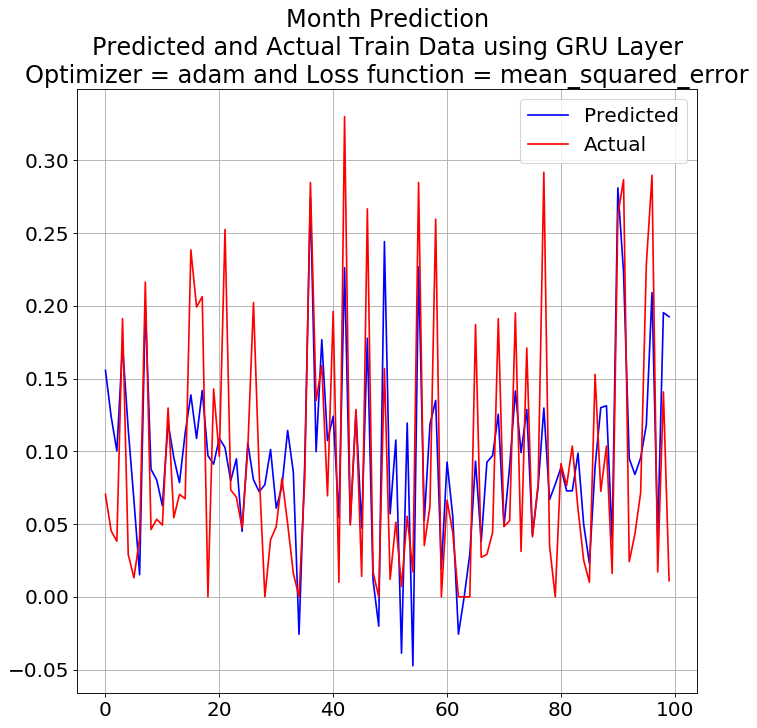

In [167]:
# Train
M = 100

index_plot_train_month = 24*7*np.arange(M) + randomDayMonth*24 + randomHourMonth

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredictMonth[index_plot_train_month, 0], 'b-', label = 'Predicted')
plt.plot(trainMonth[index_plot_train_month + window_month*24*7, 0], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Month Prediction\nPredicted and Actual Train Data using {RECURRENT} Layer\nOptimizer = {Optimizer} and Loss function = {Loss}")
plt.legend(loc="upper right")

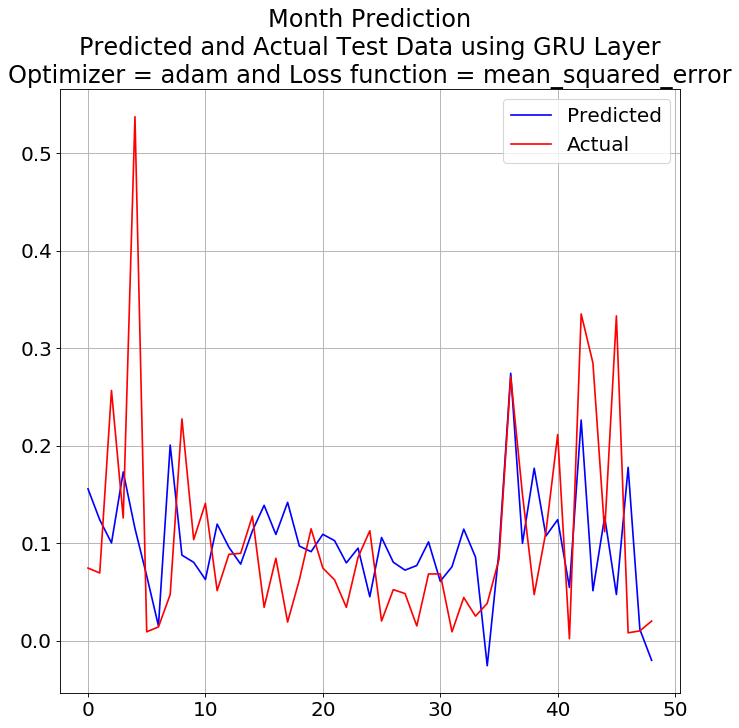

In [170]:
# Test
M = 49

index_plot_test_month = 24*7*np.arange(M) + randomDayMonth*24 + randomHourMonth

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredictMonth[index_plot_test_month, 0], 'b-', label = 'Predicted')
plt.plot(testMonth[index_plot_test_month + window_month*24*7, 0], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Month Prediction\nPredicted and Actual Test Data using {RECURRENT} Layer\nOptimizer = {Optimizer} and Loss function = {Loss}")
plt.legend(loc="upper right")

## Part 5) Dropout Layers:

In [171]:
# Splitting dataset
percentageTrain = 0.9

Num_train = int(Num_data * percentageTrain)

train = dataset[:Num_train, :]
test = dataset[Num_train:, :]

print(f"Train data shape = {train.shape}")
print(f"Test data shape = {test.shape}")

Train data shape = (39419, 8)
Test data shape = (4380, 8)


In [172]:
# Creating datasets based on window size to feed the network
window = 11
trainX, trainY = createDataset(train, window)
testX, testY = createDataset(test, window)
print(f"trainX shape = {trainX.shape} trainY shape = {trainY.shape}")
print(f"testX shape = {testX.shape} testY shape = {testY.shape}")

trainX shape = (39407, 11, 8) trainY shape = (39407,)
testX shape = (4368, 11, 8) testY shape = (4368,)


In [173]:
Results_drp = [0, 0]
Time_taken_drp = [0, 0]

In [180]:
T0 = time.time()
# create and fit the network

# We use history to plot loss and accuracy
history = History()

# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 0

# chooseOptimizer: (0 ==> adam) (1 ==> adagard)
chooseOptimizer = 0

# dropoutUse: (0 ==> don't use dropout) (1 ==> use dropout)
dropoutUse = 1

# Flag if we want to use Dropout Layers
if dropoutUse == 0:
    drop_use = False
elif dropoutUse == 1:
    drop_use = True

# Rate used in Dropout layers
Rate = 0.2

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# Number of fully connected layers
L = 1
N_neurons = 100

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_squared_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "adagard"

# Initializing model as Sequential
model = Sequential()

# Adding Recurrent layer
if Recurrent_Layer == 0:
    model.add(SimpleRNN(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 1:
    model.add(LSTM(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 2:
    model.add(GRU(units, input_shape=(window, Num_features)))
    
# Adding Dropout Layer
if drop_use == True:
    model.add(Dropout(rate = Rate))
    
# Adding fully connected layers
for i in range(L):
    model.add(Dense(N_neurons, activation = "relu"))
    
    # Adding Dropout Layer
    if drop_use == True:
        model.add(Dropout(rate = Rate))
    
# Adding output layer
model.add(Dense(1))

model.compile(loss = Loss, optimizer = Optimizer)

model.fit(trainX, trainY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

Results_drp[dropoutUse] = history.history
Time_taken_drp[dropoutUse] = time.time() - T0

Train on 35466 samples, validate on 3941 samples
Epoch 1/25
35466/35466 [==============================] - 9s 259us/sample - loss: 0.0020 - val_loss: 7.3846e-04
Epoch 2/25
35466/35466 [==============================] - 7s 199us/sample - loss: 0.0011 - val_loss: 7.0691e-04
Epoch 3/25
35466/35466 [==============================] - 7s 196us/sample - loss: 9.9924e-04 - val_loss: 6.3163e-04
Epoch 4/25
35466/35466 [==============================] - 7s 208us/sample - loss: 9.5855e-04 - val_loss: 6.2291e-04
Epoch 5/25
35466/35466 [==============================] - 7s 207us/sample - loss: 9.6221e-04 - val_loss: 6.2489e-04
Epoch 6/25
35466/35466 [==============================] - 7s 191us/sample - loss: 9.1300e-04 - val_loss: 7.6299e-04
Epoch 7/25
35466/35466 [==============================] - 7s 191us/sample - loss: 9.0297e-04 - val_loss: 6.8980e-04
Epoch 8/25
35466/35466 [==============================] - 7s 191us/sample - loss: 8.8044e-04 - val_loss: 8.7369e-04
Epoch 9/25
35466/35466 [=======

In [181]:
model.evaluate(testX, testY)

4368/4368 [==============================] - 0s 61us/sample - loss: 5.0659e-04


0.0005065926272749786

In [182]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

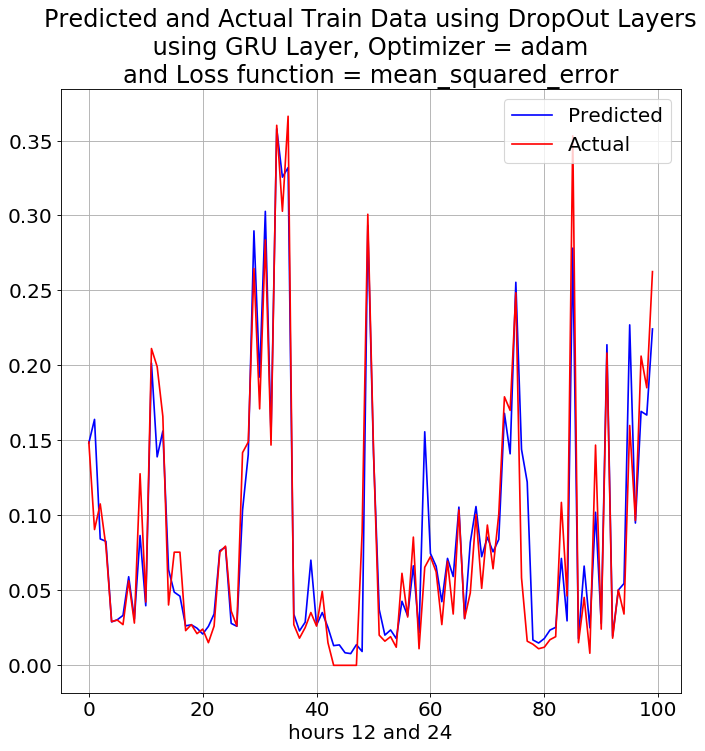

In [183]:
# Train
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"

M = 100

train_plot_range = np.arange(M)*12
    
if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredict[train_plot_range, 0], 'b-', label = 'Predicted')
plt.plot(train[train_plot_range + 12, 0], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Train Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

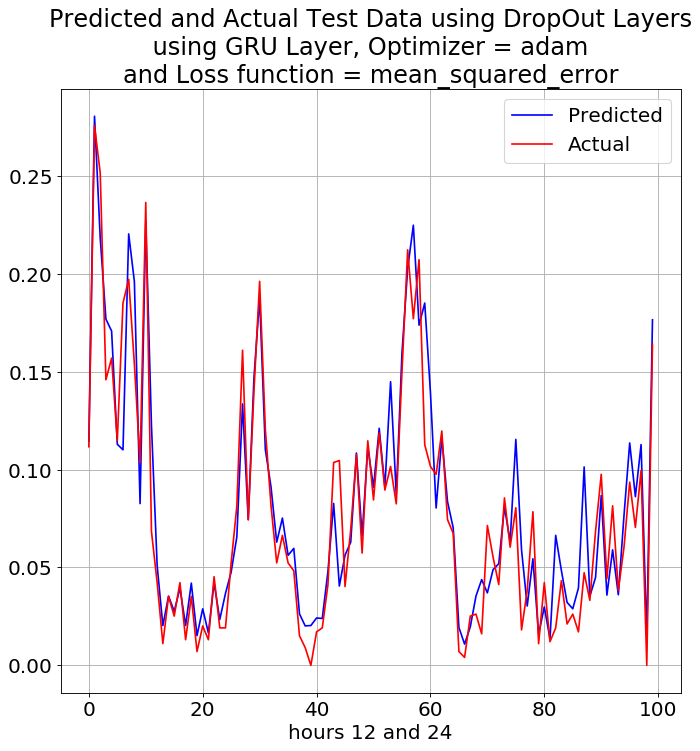

In [184]:
# Test
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"

M = 100

test_plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
M = 200
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredict[test_plot_range, 0], 'b-', label = 'Predicted')
plt.plot(test[test_plot_range+12, 0], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Test Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

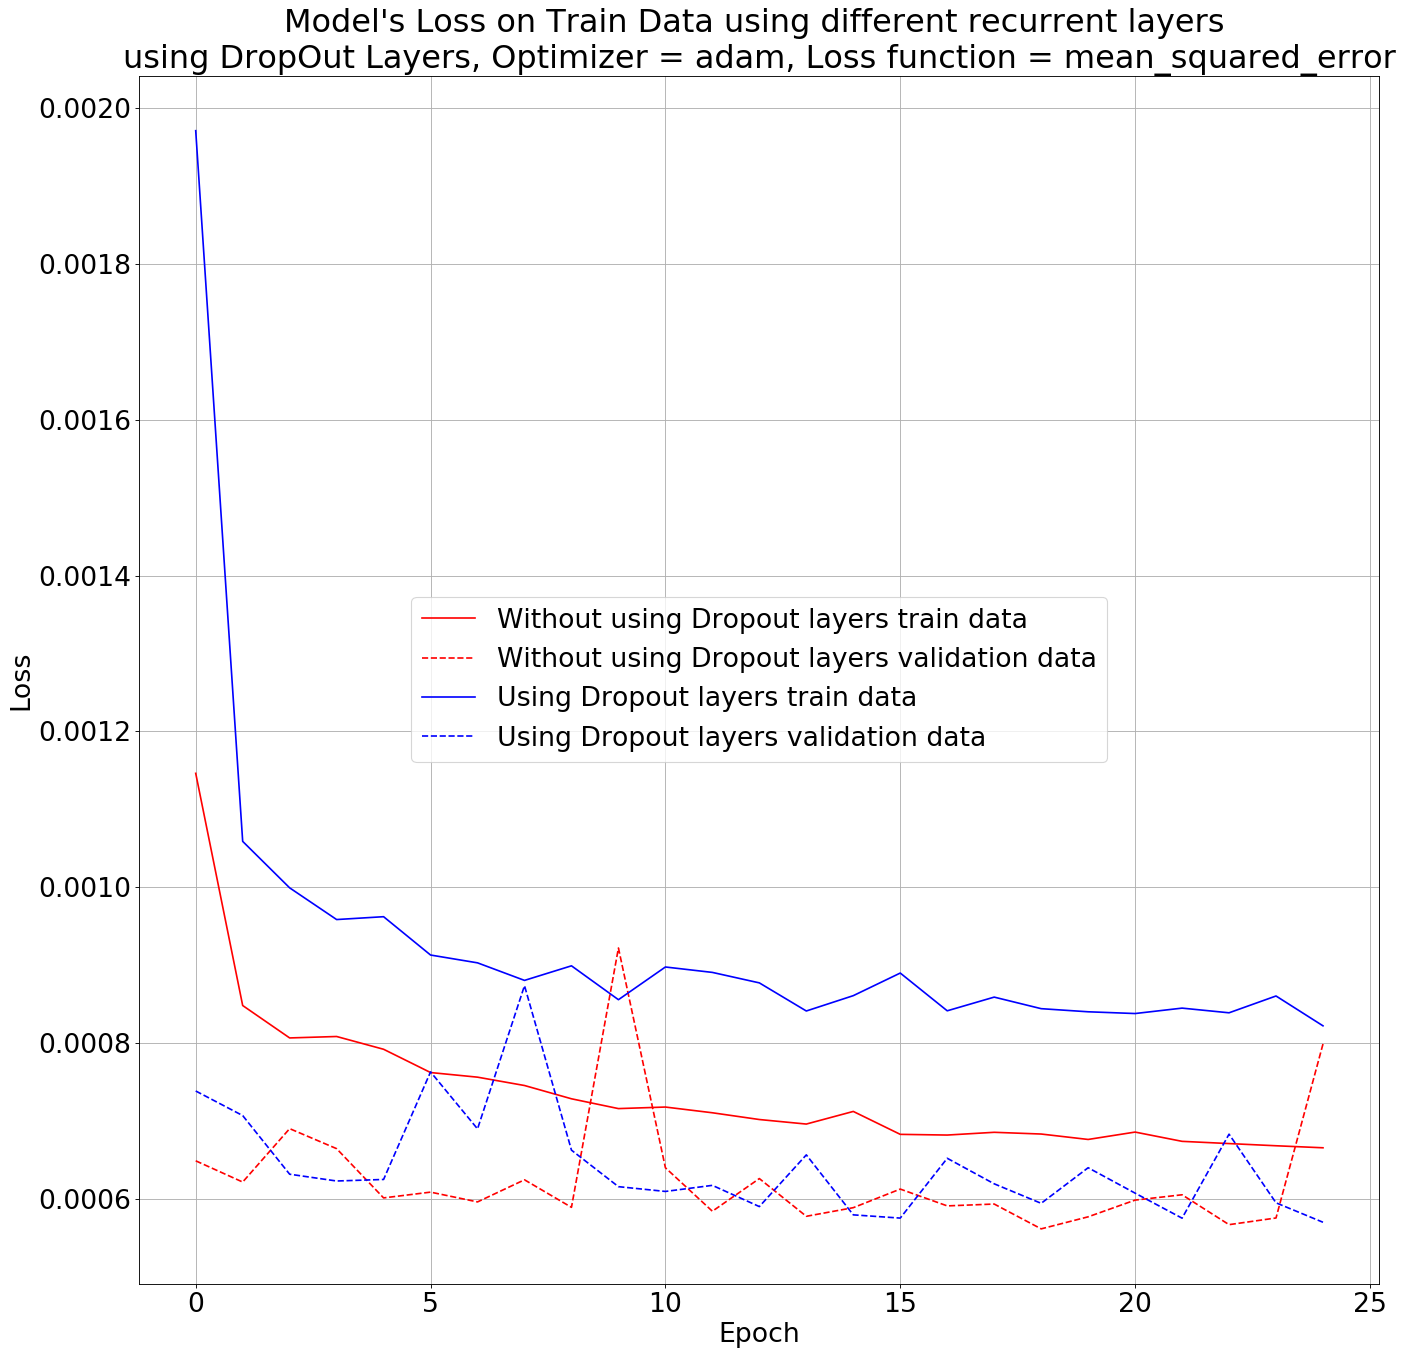

In [185]:
# Plotting Loss values
if drop_use == True:
    DROPUSE = "\nusing DropOut Layers"
else:
    DROPUSE = "without \nusing DropOut Layers"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(Results_drp[0]['loss'], 'r-', label = 'Without using Dropout layers train data')
plt.plot(Results_drp[0]['val_loss'], 'r--', label = 'Without using Dropout layers validation data')
plt.plot(Results_drp[1]['loss'], 'b-', label = 'Using Dropout layers train data')
plt.plot(Results_drp[1]['val_loss'], 'b--', label = 'Using Dropout layers validation data')
plt.title(f"Model's Loss on Train Data using different recurrent layers {DROPUSE}, Optimizer = {Optimizer}, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="center")
plt.show()

In [187]:
print(f"Time taken without using dropout layer = {Time_taken_drp[0]} seconds")
print(f"Time taken using dropout layer = {Time_taken_drp[1]} seconds")

Time taken without using dropout layer = 194.24439573287964 seconds
Time taken using dropout layer = 183.86869382858276 seconds


## Part 6) Fusion Layer:

In [7]:
train_percentage = 0.9
Num_train = int(Num_data*train_percentage)
train = dataset[:Num_train, :]
test = dataset[Num_train:, :]

# Choosing window size of three neural networks window1 < window2 < window3
window1 = 5
window2 = 12
window3 = 20
train1X, _ = createDataset(train, window=window1, smpl=1, stride=1, predicting_feature=0)
train2X, _ = createDataset(train, window=window2, smpl=1, stride=1, predicting_feature=0)
train3X, trainY = createDataset(train, window=window3, smpl=1, stride=1, predicting_feature=0)

test1X, _ = createDataset(test, window=window1, smpl=1, stride=1, predicting_feature=0)
test2X, _ = createDataset(test, window=window2, smpl=1, stride=1, predicting_feature=0)
test3X, testY = createDataset(test, window=window3, smpl=1, stride=1, predicting_feature=0)

# Synchronizing train datasets
train1X = train1X[(window3 - window1):]
print(f"train1X shape = {train1X.shape}")

train2X = train2X[(window3 - window2):]
print(f"train2X shape = {train2X.shape}")

print(f"train3X shape = {train3X.shape}")
print(f"trainY shape = {trainY.shape}\n")

# Synchronizing test datasets
test1X = test1X[(window3 - window1):]
print(f"test1X shape = {test1X.shape}")

test2X = test2X[(window3 - window2):]
print(f"test2X shape = {test2X.shape}")

print(f"test3X shape = {test3X.shape}")
print(f"testY shape = {testY.shape}\n")

train1X shape = (39398, 5, 8)
train2X shape = (39398, 12, 8)
train3X shape = (39398, 20, 8)
trainY shape = (39398,)

test1X shape = (4359, 5, 8)
test2X shape = (4359, 12, 8)
test3X shape = (4359, 20, 8)
testY shape = (4359,)



## model 1:

In [11]:
# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# fully connected layer
N_neurons = 100

# Initializing model as Sequential
input1 = Input(shape=(window1, Num_features))

# Adding Recurrent layer
if Recurrent_Layer == 0:
    rec1 = SimpleRNN(units)(input1)
elif Recurrent_Layer == 1:
    rec1 = LSTM(units)(input1)
elif Recurrent_Layer == 2:
    rec1 = GRU(units)(input1)
    
# Adding fully connected layer
dns1 = Dense(N_neurons, activation = "relu")(rec1)
    
# Adding output layer
out1 = Dense(1)(dns1)

## model 2:

In [12]:
# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# fully connected layer
N_neurons = 100

# Initializing model as Sequential
input2 = Input(shape=(window2, Num_features))

# Adding Recurrent layer
if Recurrent_Layer == 0:
    rec2 = SimpleRNN(units)(input2)
elif Recurrent_Layer == 1:
    rec2 = LSTM(units)(input2)
elif Recurrent_Layer == 2:
    rec2 = GRU(units)(input2)
    
# Adding fully connected layer
dns2 = Dense(N_neurons, activation = "relu")(rec2)
    
# Adding output layer
out2 = Dense(1)(dns2)

## model 3:

In [13]:
# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# fully connected layer
N_neurons = 100

# Initializing model as Sequential
input3 = Input(shape=(window3, Num_features))

# Adding Recurrent layer
if Recurrent_Layer == 0:
    rec3 = SimpleRNN(units)(input3)
elif Recurrent_Layer == 1:
    rec3 = LSTM(units)(input3)
elif Recurrent_Layer == 2:
    rec3 = GRU(units)(input3)
    
# Adding fully connected layer
dns3 = Dense(N_neurons, activation = "relu")(rec3)
    
# Adding output layer
out3 = Dense(1)(dns3)

## Parallel and average three networks:

In [14]:
avg = Average()([out1, out2, out3])
model = tf.keras.models.Model(inputs=[input1, input2, input3], outputs=avg)

In [15]:
Results_fusion = [0, 0, 0]
test_evaluation_fusion = [0, 0, 0]

In [16]:
# We use history to plot loss and accuracy
history = History()

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 0

# chooseOptimizer: (0 ==> adam) (1 ==> adagard)
chooseOptimizer = 0

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_squared_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "adagard"

model.compile(loss = Loss, optimizer = Optimizer, metrics = ['mean_squared_error', 'mean_absolute_error'])

model.fit([train1X, train2X, train3X], y=trainY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

Results_fusion[Recurrent_Layer] = history.history
test_evaluation_fusion[Recurrent_Layer] = model.evaluate([test1X, test2X, test3X], testY)

Train on 35458 samples, validate on 3940 samples
Epoch 1/25
35458/35458 [==============================] - 17s 480us/sample - loss: 0.0011 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0197 - val_loss: 6.9069e-04 - val_mean_squared_error: 6.9069e-04 - val_mean_absolute_error: 0.0146
Epoch 2/25
35458/35458 [==============================] - 12s 326us/sample - loss: 8.4011e-04 - mean_squared_error: 8.4011e-04 - mean_absolute_error: 0.0163 - val_loss: 6.3199e-04 - val_mean_squared_error: 6.3199e-04 - val_mean_absolute_error: 0.0137
Epoch 3/25
35458/35458 [==============================] - 12s 346us/sample - loss: 8.2854e-04 - mean_squared_error: 8.2854e-04 - mean_absolute_error: 0.0161 - val_loss: 8.1472e-04 - val_mean_squared_error: 8.1472e-04 - val_mean_absolute_error: 0.0172
Epoch 4/25
35458/35458 [==============================] - 12s 338us/sample - loss: 8.0710e-04 - mean_squared_error: 8.0710e-04 - mean_absolute_error: 0.0157 - val_loss: 6.6569e-04 - val_mean_squared_error: 

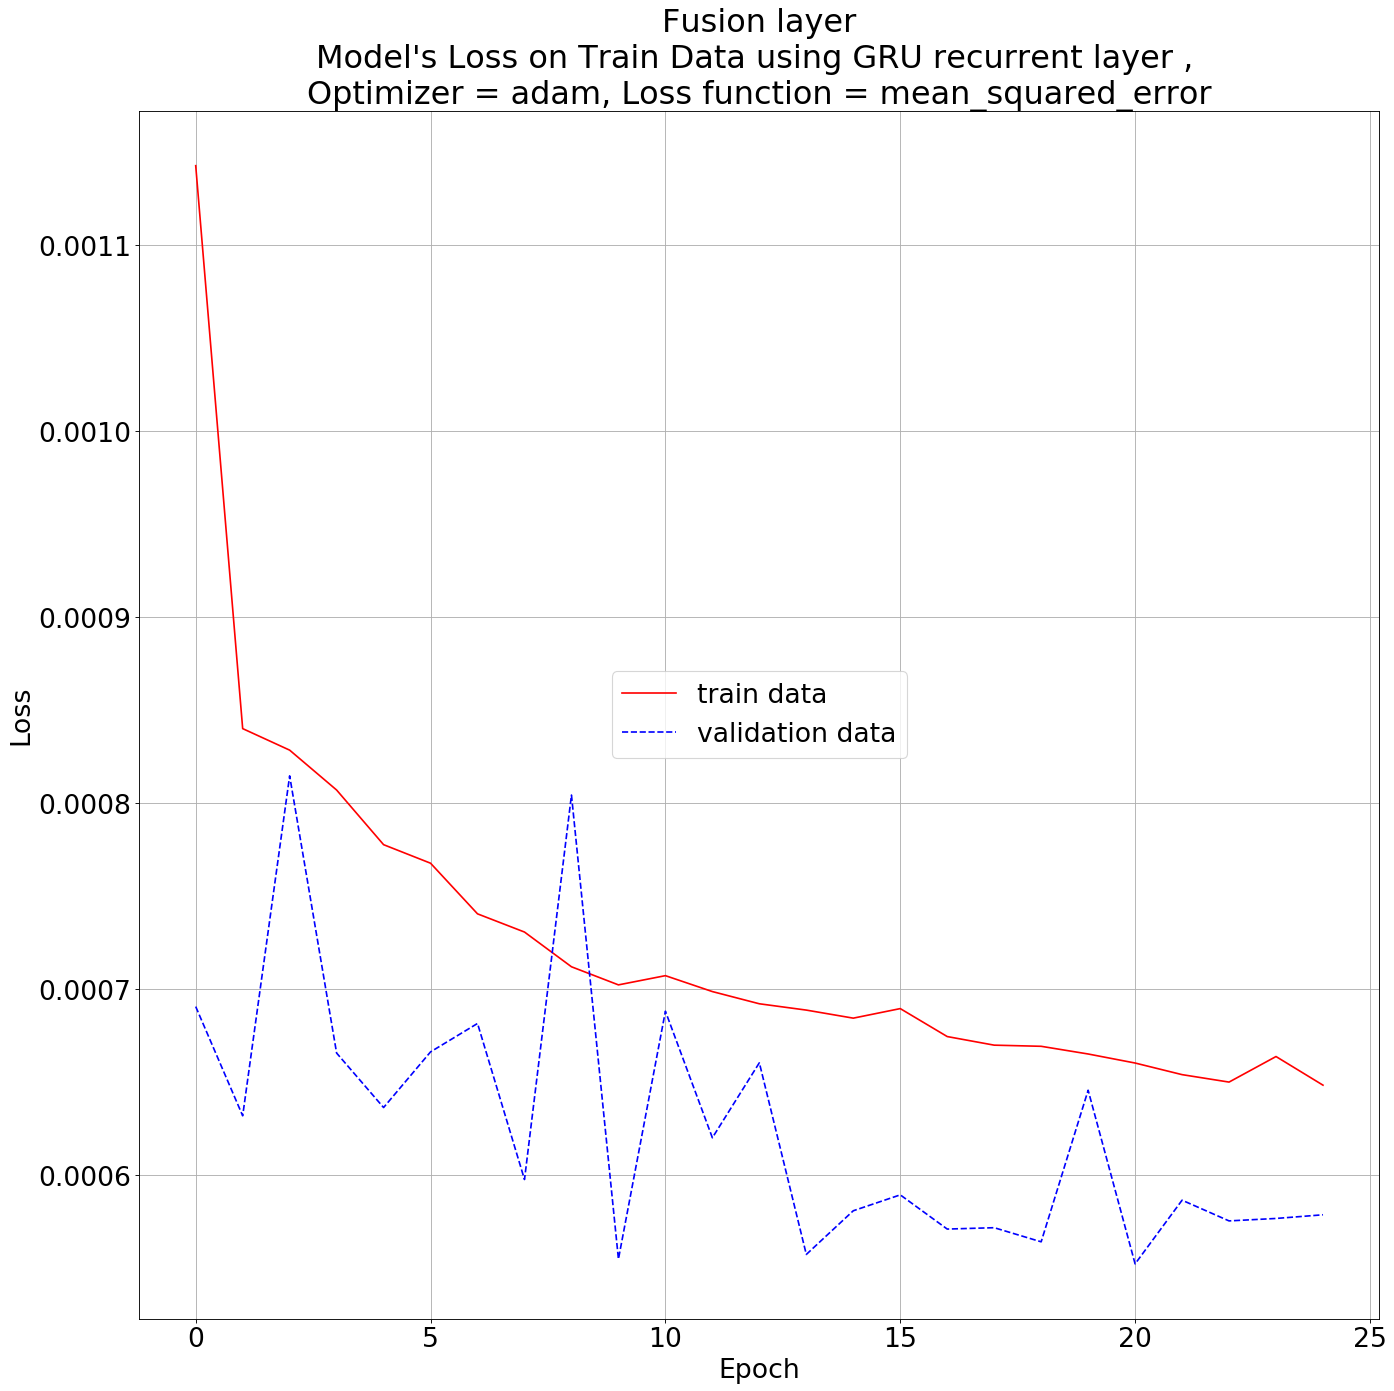

In [24]:
# Plotting Loss values

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(Results_fusion[Recurrent_Layer]['loss'], 'r-', label = 'train data')
plt.plot(Results_fusion[Recurrent_Layer]['val_loss'], 'b--', label = 'validation data')
plt.title(f"Fusion layer\nModel's Loss on Train Data using {RECURRENT} recurrent layer , \nOptimizer = {Optimizer}, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="center")
plt.show()

In [17]:
# make predictions
trainPredict = model.predict([train1X, train2X, train3X])
testPredict = model.predict([test1X, test2X, test3X])

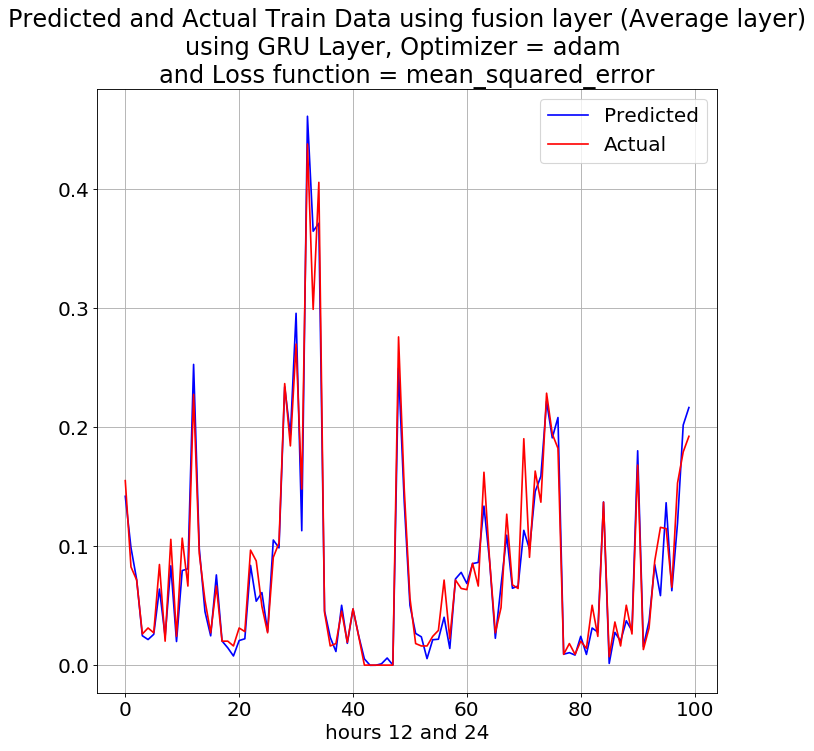

In [18]:
# Train
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(trainY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Train Data using fusion layer (Average layer)\nusing {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

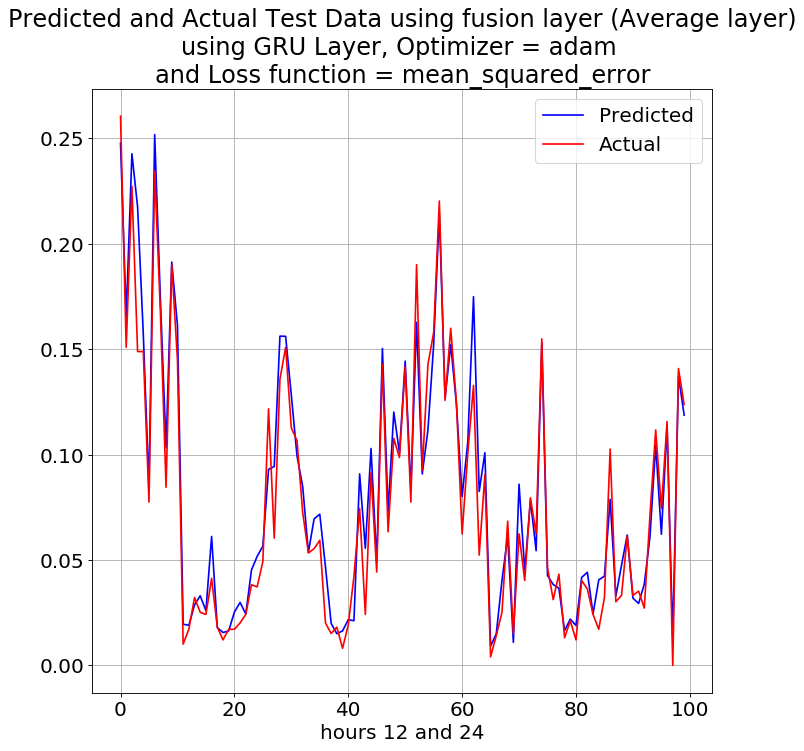

In [27]:
# Test
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(testY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Test Data using fusion layer (Average layer)\nusing {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

## Test evaluations:

In [23]:
print(f"GRU layer:")
print(f"MSE = {test_evaluation_fusion[2][0]}, MAE = {test_evaluation_fusion[2][1]}")

GRU layer:
MSE = 0.00047067118286435705, MAE = 0.00047067113337107003


## Part 7 & 8) Choosing two columns

In [28]:
feature_names = ["pollution", "dew", "temp", "pressure", "wind_dir", "wind_spd", "snow", "rain"]
df = pd.DataFrame(dataset, columns = feature_names)
df

pollution       dew      temp  pressure  wind_dir  wind_spd      snow  \
0       0.129779  0.352941  0.245902  0.527273  0.666667  0.002290  0.000000   
1       0.148893  0.367647  0.245902  0.527273  0.666667  0.003811  0.000000   
2       0.159960  0.426471  0.229508  0.545454  0.666667  0.005332  0.000000   
3       0.182093  0.485294  0.229508  0.563637  0.666667  0.008391  0.037037   
4       0.138833  0.485294  0.229508  0.563637  0.666667  0.009912  0.074074   
...          ...       ...       ...       ...       ...       ...       ...   
43794   0.010060  0.264706  0.278689  0.763638  0.333333  0.385730  0.000000   
43795   0.008048  0.250000  0.278689  0.781818  0.333333  0.395659  0.000000   
43796   0.010060  0.264706  0.262295  0.781818  0.333333  0.405588  0.000000   
43797   0.010060  0.264706  0.262295  0.781818  0.333333  0.413996  0.000000   
43798   0.008048  0.264706  0.245902  0.781818  0.333333  0.420866  0.000000   

       rain  
0       0.0  
1       0.0  
2       0.0  
3       0.0  
4       0.0  
...     ...  
43794   0.0  
43795   0.0  
43796   0.0  
43797   0.0  
43798   0.0  

[43799 rows x 8 columns]

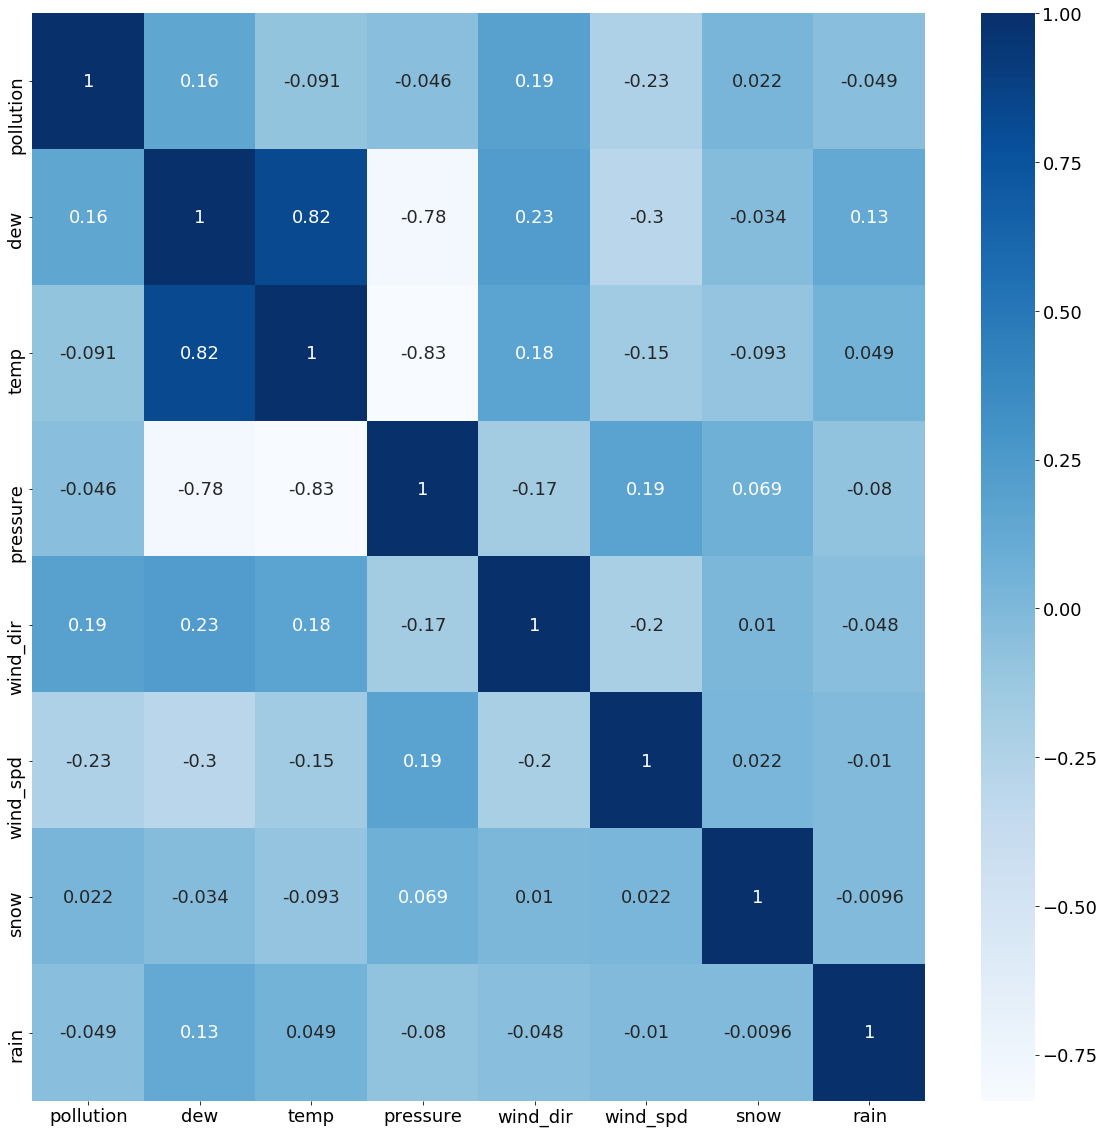

In [29]:
import seaborn as sn

# Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = df.corr()
sn.heatmap(cor, annot=True, cmap="Blues")
plt.show()

### So we choose wind_spd and wind_dir features.

In [39]:
index_chosen_features = np.array([0, 4, 5])
name_chosen_features = [feature_names[0], feature_names[4], feature_names[5]]
Num_newfeatures = len(index_chosen_features)
newDataset = dataset[:, index_chosen_features]
print(newDataset.shape)

(43799, 3)


In [31]:
# Splitting Datasets
percentageTrain = 0.8
N_train = int(percentageTrain * Num_data)

train = newDataset[:N_train, :]
test = newDataset[N_train:, :]

In [32]:
window = 11
trainX, trainY = createDataset(train, window, smpl=1, stride=1, predicting_feature=0)
testX, testY = createDataset(test, window, smpl=1, stride=1, predicting_feature=0)
print(f"trainX shape = {trainX.shape} trainY shape = {trainY.shape}")
print(f"testX shape = {testX.shape} testY shape = {testY.shape}")

trainX shape = (35027, 11, 3) trainY shape = (35027,)
testX shape = (8748, 11, 3) testY shape = (8748,)


In [35]:
Results_part8 = [0, 0, 0]
Time_taken_part8 = [0, 0, 0]
Test_evaluation_part8 = [0, 0, 0]

In [48]:
T0 = time.time()
# create and fit the network

# We use history to plot loss and accuracy
history = History()

# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 0

# chooseOptimizer: (0 ==> adam) (1 ==> adagard)
chooseOptimizer = 0

# dropoutUse: (0 ==> don't use dropout) (1 ==> use dropout)
dropoutUse = 0

# Flag if we want to use Dropout Layers
if dropoutUse == 0:
    drop_use = False
elif dropoutUse == 1:
    drop_use = True

# Rate used in Dropout layers
Rate = 0.2

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# Number of fully connected layers
L = 1
N_neurons = 100

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_squared_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "adagard"

# Initializing model as Sequential
model = Sequential()

# Adding Recurrent layer
if Recurrent_Layer == 0:
    model.add(SimpleRNN(units, input_shape=(window, Num_newfeatures)))
elif Recurrent_Layer == 1:
    model.add(LSTM(units, input_shape=(window, Num_newfeatures)))
elif Recurrent_Layer == 2:
    model.add(GRU(units, input_shape=(window, Num_newfeatures)))
    
# Adding Dropout Layer
if drop_use == True:
    model.add(Dropout(rate = Rate))
    
# Adding fully connected layers
for i in range(L):
    model.add(Dense(N_neurons, activation = "relu"))
    
    # Adding Dropout Layer
    if drop_use == True:
        model.add(Dropout(rate = Rate))
    
# Adding output layer
model.add(Dense(1))

model.compile(loss = Loss, optimizer = Optimizer)

model.fit(trainX, trainY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

Results_part8[Recurrent_Layer] = history.history
Time_taken_part8[Recurrent_Layer] = time.time() - T0
Test_evaluation_part8[Recurrent_Layer] = model.evaluate(testX, testY)

Train on 31524 samples, validate on 3503 samples
Epoch 1/25
31524/31524 [==============================] - 7s 231us/sample - loss: 0.0011 - val_loss: 6.0041e-04
Epoch 2/25
31524/31524 [==============================] - 7s 214us/sample - loss: 8.4950e-04 - val_loss: 6.5883e-04
Epoch 3/25
31524/31524 [==============================] - 8s 259us/sample - loss: 8.3568e-04 - val_loss: 6.5630e-04
Epoch 4/25
31524/31524 [==============================] - 8s 248us/sample - loss: 8.3193e-04 - val_loss: 5.7334e-04
Epoch 5/25
31524/31524 [==============================] - 6s 197us/sample - loss: 8.3006e-04 - val_loss: 5.6382e-04
Epoch 6/25
31524/31524 [==============================] - 6s 201us/sample - loss: 8.0419e-04 - val_loss: 5.7366e-04
Epoch 7/25
31524/31524 [==============================] - 6s 185us/sample - loss: 7.9638e-04 - val_loss: 6.4951e-04
Epoch 8/25
31524/31524 [==============================] - 6s 184us/sample - loss: 7.7638e-04 - val_loss: 6.7125e-04
Epoch 9/25
31524/31524 [===

In [49]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

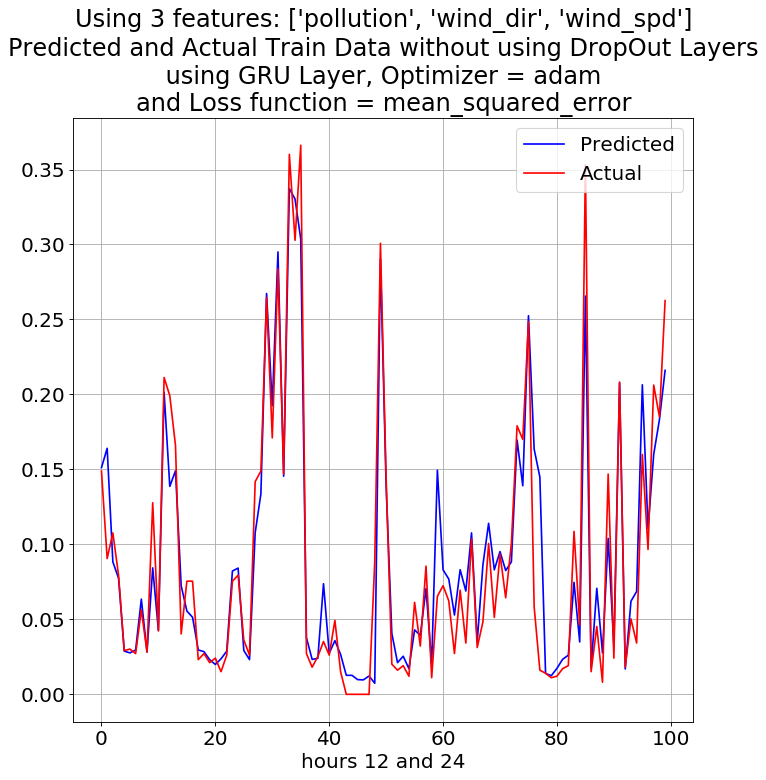

In [50]:
# Train
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"

M = 100

train_plot_range = np.arange(M)*12
    
if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredict[train_plot_range, 0], 'b-', label = 'Predicted')
plt.plot(train[train_plot_range + 12, 0], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Using {Num_newfeatures} features: {name_chosen_features}\nPredicted and Actual Train Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

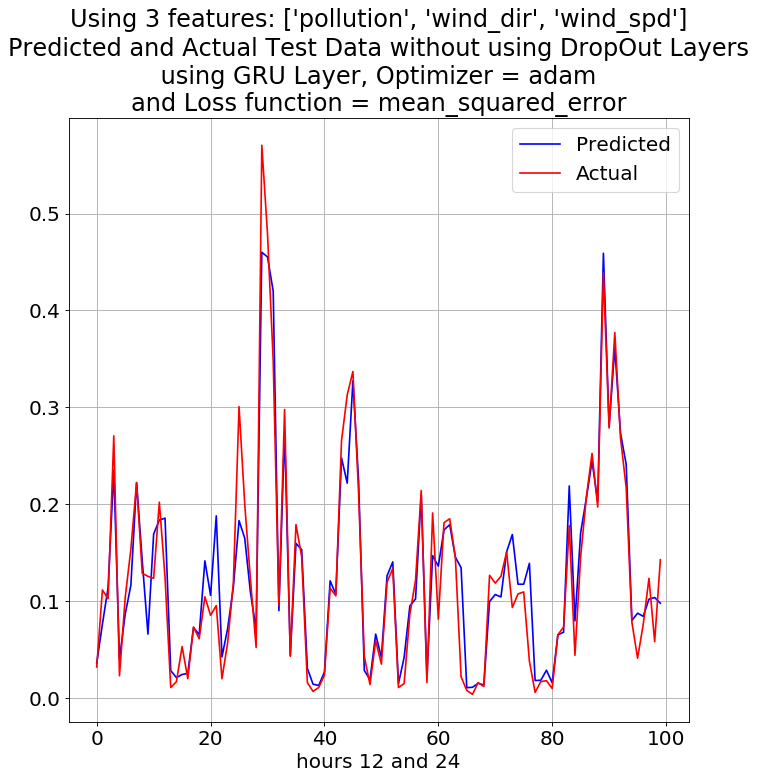

In [51]:
# Test
if drop_use == True:
    DROPUSE = "using DropOut Layers"
else:
    DROPUSE = "without using DropOut Layers"

M = 100

test_plot_range = np.arange(M)*12
    
if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredict[test_plot_range, 0], 'b-', label = 'Predicted')
plt.plot(test[test_plot_range + 12, 0], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Using {Num_newfeatures} features: {name_chosen_features}\nPredicted and Actual Test Data {DROPUSE}\n using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

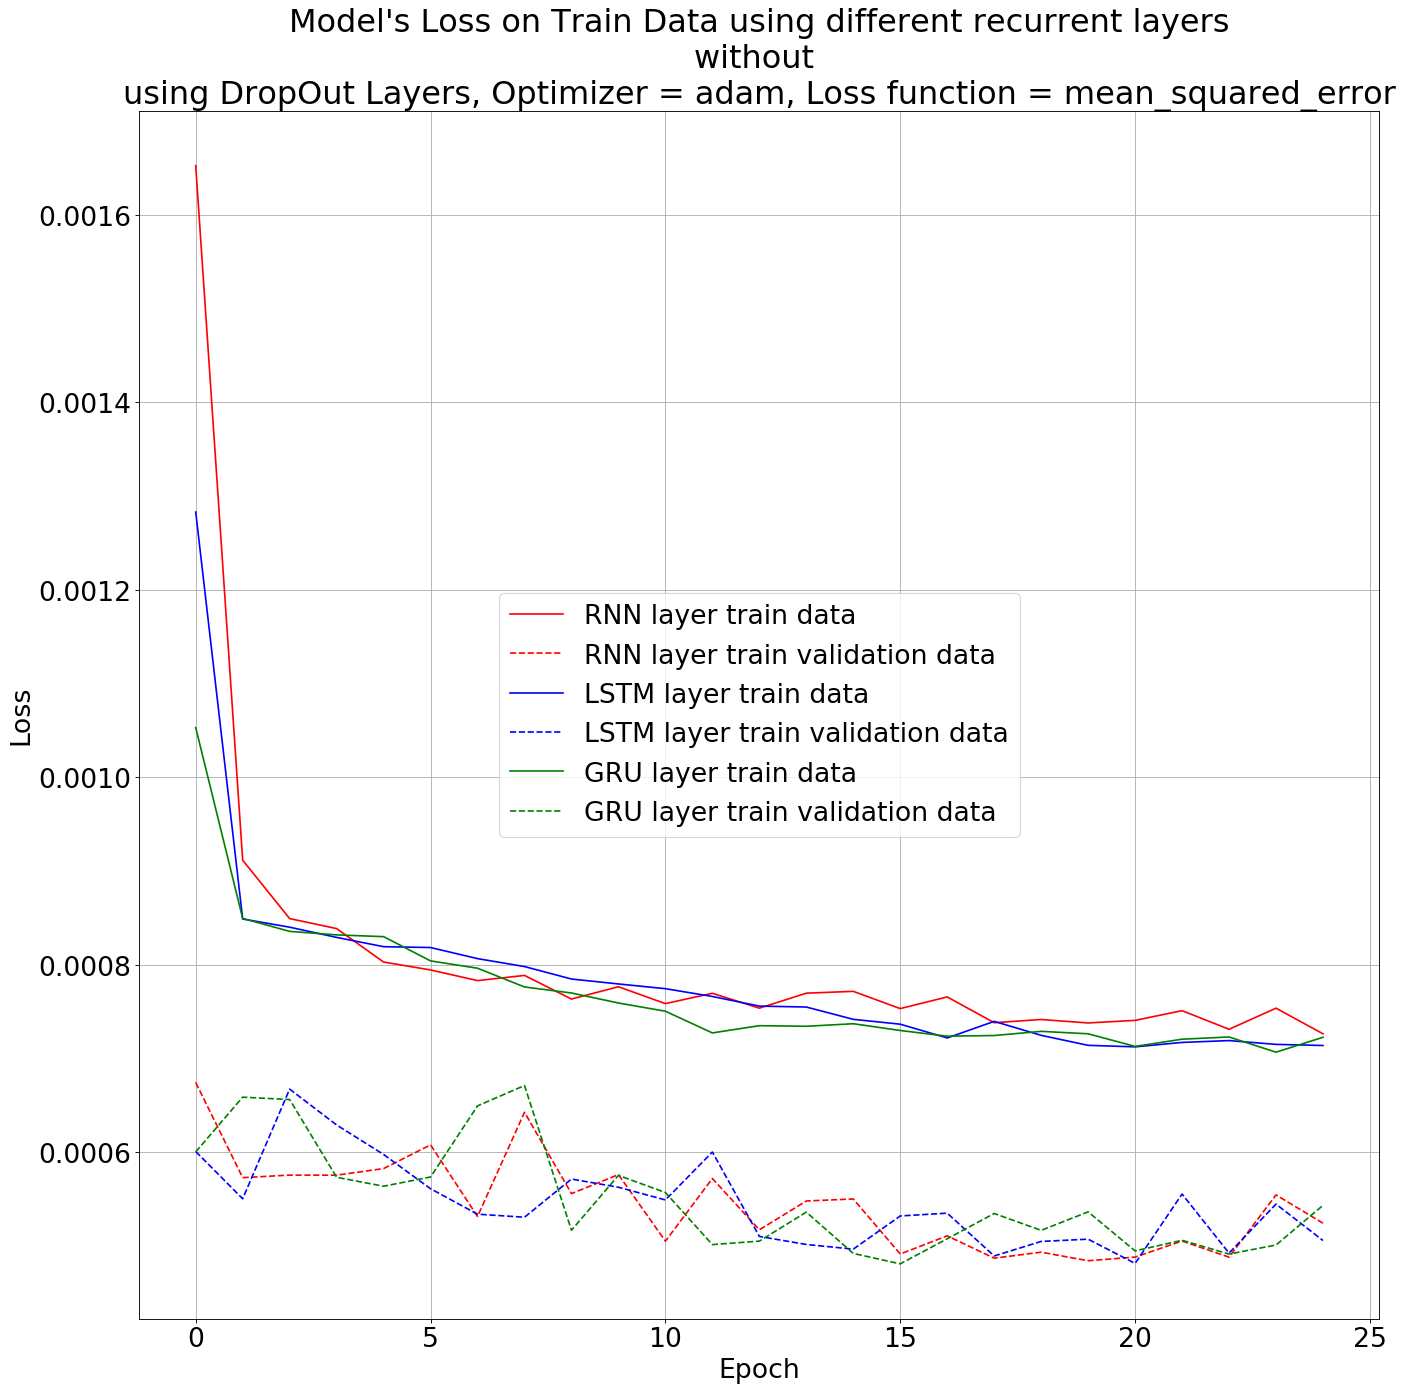

In [52]:
# Plotting Loss values
if drop_use == True:
    DROPUSE = "\nusing DropOut Layers"
else:
    DROPUSE = "without \nusing DropOut Layers"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(Results_part8[0]['loss'], 'r-', label = 'RNN layer train data')
plt.plot(Results_part8[0]['val_loss'], 'r--', label = 'RNN layer train validation data')
plt.plot(Results_part8[1]['loss'], 'b-', label = 'LSTM layer train data')
plt.plot(Results_part8[1]['val_loss'], 'b--', label = 'LSTM layer train validation data')
plt.plot(Results_part8[2]['loss'], 'g-', label = 'GRU layer train data')
plt.plot(Results_part8[2]['val_loss'], 'g--', label = 'GRU layer train validation data')
plt.title(f"Model's Loss on Train Data using different recurrent layers\n{DROPUSE}, Optimizer = {Optimizer}, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="center")
plt.show()

In [54]:
print("RNN layer:")
print(f"Time taken = {Time_taken_part8[0]} seconds")
print(f"Test evaluation:")
print(f"MSE={Test_evaluation_part8[0]}")
print('\n')

print("LSTM layer:")
print(f"Time taken = {Time_taken_part8[1]} seconds")
print(f"Test evaluation:")
print(f"MSE={Test_evaluation_part8[1]}")
print('\n')


print("GRU layer:")
print(f"Time taken = {Time_taken_part8[2]} seconds")
print(f"Test evaluation:")
print(f"MSE={Test_evaluation_part8[2]}")

RNN layer:
Time taken = 81.46726584434509 seconds
Test evaluation:
MSE=0.0005893364506599387


LSTM layer:
Time taken = 141.17907571792603 seconds
Test evaluation:
MSE=0.0005763707063721221


GRU layer:
Time taken = 458.7524981498718 seconds
Test evaluation:
MSE=0.0006498267014349335


# Missing Values:

In [157]:
dataset_missing = np.copy(dataset).astype('float64')
remove_percentage = 0.2
N_delete = int(remove_percentage * Num_data)
nan_vec = np.NaN * np.zeros(N_delete)
deleted_index = np.zeros((N_delete, Num_features))
actual_data = np.zeros((N_delete, Num_features))

for i in range(Num_features):
    index = np.random.randint(Num_data, size = N_delete)
    deleted_index[:, i] = index
    actual_data[:, i] = dataset_missing[index, i]
    dataset_missing[index, i] = nan_vec
deleted_index = deleted_index.astype('int')

In [158]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as MSE
from impyute.imputation.cs import mice
feature_names = ["pollution", "dew", "temp", "pressure", "wind_dir", "wind_spd", "snow", "rain"]

## Strategy 1 :Filling missing values with zero:

In [168]:
#Impute the values using scikit-learn SimpleImpute Class

imp_zero = SimpleImputer(strategy='constant', fill_value = 0)
imp_zero.fit(dataset_missing)
imputed_dataset_strategy1 = imp_zero.transform(dataset_missing).astype('float64')
strategy1_mse = np.zeros(Num_features)

for i in range(Num_features):
    strategy1_mse[i] = MSE(actual_data[:, i], imputed_dataset_strategy1[deleted_index[:, i], i])
    
strategy1_mse

array([0.01813271, 0.42444218, 0.30781448, 0.2505557 , 0.4035849 ,
       0.00902167, 0.00083207, 0.00152136])

## Strategy 2 :Using mean of existing data:

In [161]:
#Impute the values using scikit-learn SimpleImpute Class

imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(dataset_missing)
imputed_dataset_strategy2 = imp_mean.transform(dataset_missing).astype('float64')
strategy2_mse = np.zeros(Num_features)

for i in range(Num_features):
    strategy2_mse[i] = MSE(actual_data[:, i], imputed_dataset_strategy2[deleted_index[:, i], i])
    
strategy2_mse

array([0.00900863, 0.04583787, 0.03966971, 0.03478819, 0.09863287,
       0.00738221, 0.00082803, 0.00149637])

In [183]:
np.count_nonzero(np.isnan(imputed_dataset))

0

## Strategy 3 :Using median of existing data:

In [162]:
#Impute the values using scikit-learn SimpleImpute Class

imp_median = SimpleImputer(strategy='median')
imp_median.fit(dataset_missing)
imputed_dataset_strategy3 = imp_median.transform(dataset_missing).astype('float64')
strategy3_mse = np.zeros(Num_features)

for i in range(Num_features):
    strategy3_mse[i] = MSE(actual_data[:, i], imputed_dataset_strategy3[deleted_index[:, i], i])

strategy3_mse

array([0.00974259, 0.04584333, 0.04019874, 0.0348821 , 0.11172001,
       0.00841142, 0.00083207, 0.00152136])

## Strategy 4: Imputation Using Multivariate Imputation by Chained Equation (MICE):

In [163]:
# MICE strategy

imputed_dataset_strategy4 = mice(dataset_missing)
strategy4_mse = np.zeros(Num_features)

for i in range(Num_features):
    strategy4_mse[i] = MSE(actual_data[:, i], imputed_dataset_strategy4[deleted_index[:, i], i])

strategy4_mse

array([0.00759193, 0.01313771, 0.01043478, 0.01165715, 0.09051868,
       0.00647876, 0.00081784, 0.00148234])

## Strategy 5: Imputation Using Interpolation:

In [165]:
# Interpolation strategy

df_missed = pd.DataFrame(dataset_missing, columns = feature_names)
imputed_dataset_strategy5 = df_missed.interpolate(method ='nearest').values

imputed_dataset_strategy5 = imputed_dataset_strategy5.astype('float64')
imp_mean = SimpleImputer(strategy='mean')
imp_mean.fit(imputed_dataset_strategy5)
imputed_dataset_strategy5 = imp_mean.transform(imputed_dataset_strategy5).astype('float64')
strategy5_mse = np.zeros(Num_features)

for i in range(Num_features):
    strategy5_mse[i] = MSE(actual_data[:, i], imputed_dataset_strategy5[deleted_index[:, i], i])

strategy5_mse
#df_missed

array([7.21251908e-04, 4.23242374e-04, 6.60784386e-04, 1.65911945e-04,
       1.16071087e-01, 8.05163575e-04, 4.93319766e-05, 4.31919064e-04])

In [169]:
strategies_mse = np.zeros((5, Num_features))

strategies_mse[0, :] = strategy1_mse
strategies_mse[1, :] = strategy2_mse
strategies_mse[2, :] = strategy3_mse
strategies_mse[3, :] = strategy4_mse
strategies_mse[4, :] = strategy5_mse

strategies_mse_df = pd.DataFrame(strategies_mse, index=['zero fill', 'mean', 'median', 'mice', 'Interpolation'], columns = feature_names)
strategies_mse_df

pollution       dew      temp  pressure  wind_dir  wind_spd  \
zero fill       0.018133  0.424442  0.307814  0.250556  0.403585  0.009022   
mean            0.009009  0.045838  0.039670  0.034788  0.098633  0.007382   
median          0.009743  0.045843  0.040199  0.034882  0.111720  0.008411   
mice            0.007592  0.013138  0.010435  0.011657  0.090519  0.006479   
Interpolation   0.000721  0.000423  0.000661  0.000166  0.116071  0.000805   

                   snow      rain  
zero fill      0.000832  0.001521  
mean           0.000828  0.001496  
median         0.000832  0.001521  
mice           0.000818  0.001482  
Interpolation  0.000049  0.000432

In [170]:
# Splitting dataset
train_percentage = 0.9
N_train = int(train_percentage*Num_data)

train = imputed_dataset_strategy5[:N_train, :]
test = imputed_dataset_strategy5[N_train:, :]

In [171]:
window = 11
trainX, trainY = createDataset(train, window, smpl=1, stride=1, predicting_feature=0)
testX, testY = createDataset(test, window, smpl=1, stride=1, predicting_feature=0)
print(f"trainX shape = {trainX.shape} trainY shape = {trainY.shape}")
print(f"testX shape = {testX.shape} testY shape = {testY.shape}")

trainX shape = (39407, 11, 8) trainY shape = (39407,)
testX shape = (4368, 11, 8) testY shape = (4368,)


In [175]:
Results_last = [0, 0]
Time_taken_last = [0, 0]
Test_evaluation_last = [0, 0]

In [181]:
T0 = time.time()
# create and fit the network

# We use history to plot loss and accuracy
history = History()

# Recurrent_Layer: (0 ==> RNN) (1 ==> LSTM) (2 ==> GRU)
Recurrent_Layer = 2

# Number of units:
units = 50

# chooseLoss: (0 ==> MSE) (1 ==> MAE)
chooseLoss = 0

# chooseOptimizer: (0 ==> adam) (1 ==> adagard)
chooseOptimizer = 0

# dropoutUse: (0 ==> don't use dropout) (1 ==> use dropout)
dropoutUse = 0

# Flag if we want to use Dropout Layers
if dropoutUse == 0:
    drop_use = False
elif dropoutUse == 1:
    drop_use = True

# Rate used in Dropout layers
Rate = 0.2

# Number of epochs and batchSize
epochs = 25
batchSize = 32

# Number of fully connected layers
L = 1
N_neurons = 100

# Choosing loss function
if chooseLoss == 0:
    Loss = 'mean_squared_error'
elif chooseLoss == 1:
    Loss = 'mean_absolute_error'
    
# Choosing Optimizer
if chooseOptimizer == 0:
    Optimizer = "adam"
elif chooseOptimizer == 1:
    Optimizer = "adagard"

# Initializing model as Sequential
model = Sequential()

# Adding Recurrent layer
if Recurrent_Layer == 0:
    model.add(SimpleRNN(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 1:
    model.add(LSTM(units, input_shape=(window, Num_features)))
elif Recurrent_Layer == 2:
    model.add(GRU(units, input_shape=(window, Num_features)))
    
# Adding Dropout Layer
if drop_use == True:
    model.add(Dropout(rate = Rate))
    
# Adding fully connected layers
for i in range(L):
    model.add(Dense(N_neurons, activation = "relu"))
    
    # Adding Dropout Layer
    if drop_use == True:
        model.add(Dropout(rate = Rate))
    
# Adding output layer
model.add(Dense(1))

model.compile(loss = Loss, optimizer = Optimizer, metrics = ['mean_squared_error', 'mean_absolute_error'])

model.fit(trainX, trainY, epochs = epochs, callbacks = [history], 
          batch_size = batchSize, validation_split = 0.1)

Results_last[Recurrent_Layer-1] = history.history
Test_evaluation_last[Recurrent_Layer-1] = model.evaluate(testX, testY)
Time_taken_last[Recurrent_Layer-1] = time.time() - T0

Train on 35466 samples, validate on 3941 samples
Epoch 1/25
35466/35466 [==============================] - 9s 248us/sample - loss: 0.0010 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0190 - val_loss: 6.4998e-04 - val_mean_squared_error: 6.4998e-04 - val_mean_absolute_error: 0.0136
Epoch 2/25
35466/35466 [==============================] - 7s 193us/sample - loss: 8.3793e-04 - mean_squared_error: 8.3793e-04 - mean_absolute_error: 0.0158 - val_loss: 6.8772e-04 - val_mean_squared_error: 6.8772e-04 - val_mean_absolute_error: 0.0144
Epoch 3/25
35466/35466 [==============================] - 7s 196us/sample - loss: 8.3824e-04 - mean_squared_error: 8.3824e-04 - mean_absolute_error: 0.0160 - val_loss: 7.1730e-04 - val_mean_squared_error: 7.1730e-04 - val_mean_absolute_error: 0.0163
Epoch 4/25
35466/35466 [==============================] - 7s 196us/sample - loss: 8.1978e-04 - mean_squared_error: 8.1978e-04 - mean_absolute_error: 0.0156 - val_loss: 6.6702e-04 - val_mean_squared_error: 6.67

In [186]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

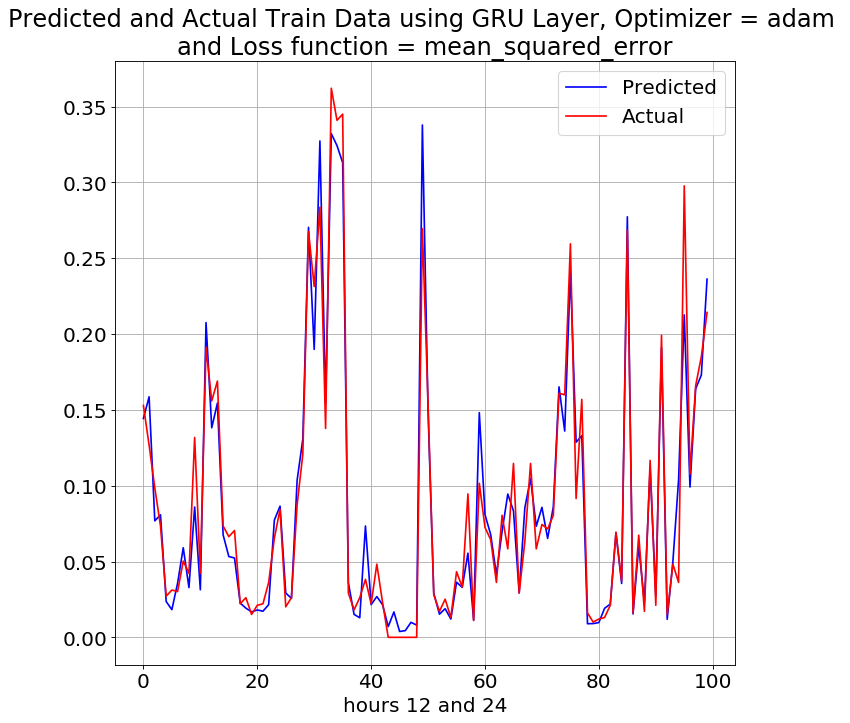

In [187]:
# Train
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(trainPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(trainY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Train Data using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

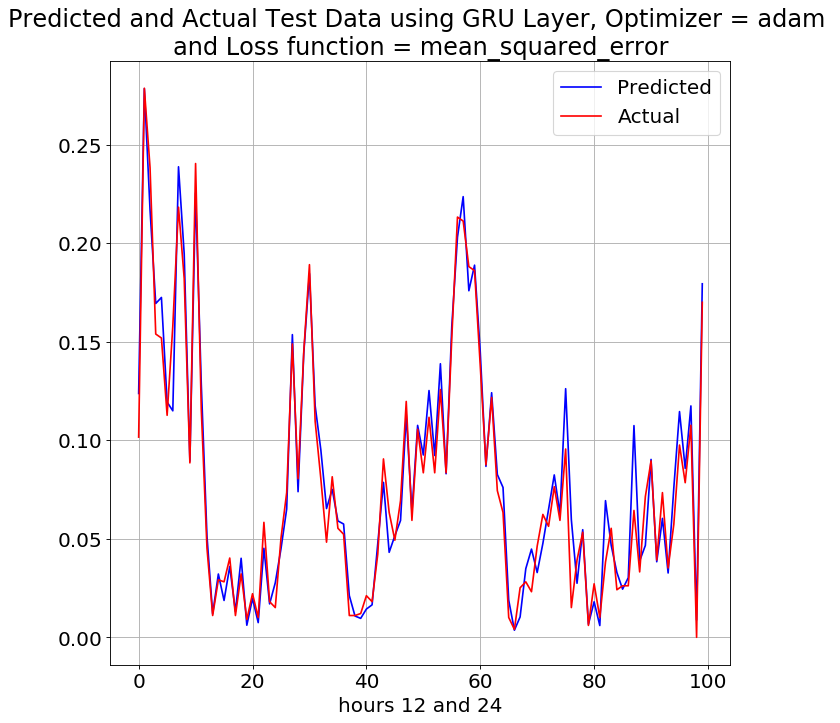

In [188]:
# Test
M = 100
plot_range = np.arange(M)*12

if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(10, 10), dpi=80, 
           facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
plt.plot(testPredict[plot_range], 'b-', label = 'Predicted')
plt.plot(testY[plot_range], 'r-', label = 'Actual')
plt.grid('on')
plt.title(f"Predicted and Actual Test Data using {RECURRENT} Layer, Optimizer = {Optimizer} \nand Loss function = {Loss}")
plt.xlabel("hours 12 and 24")
plt.legend(loc="upper right")

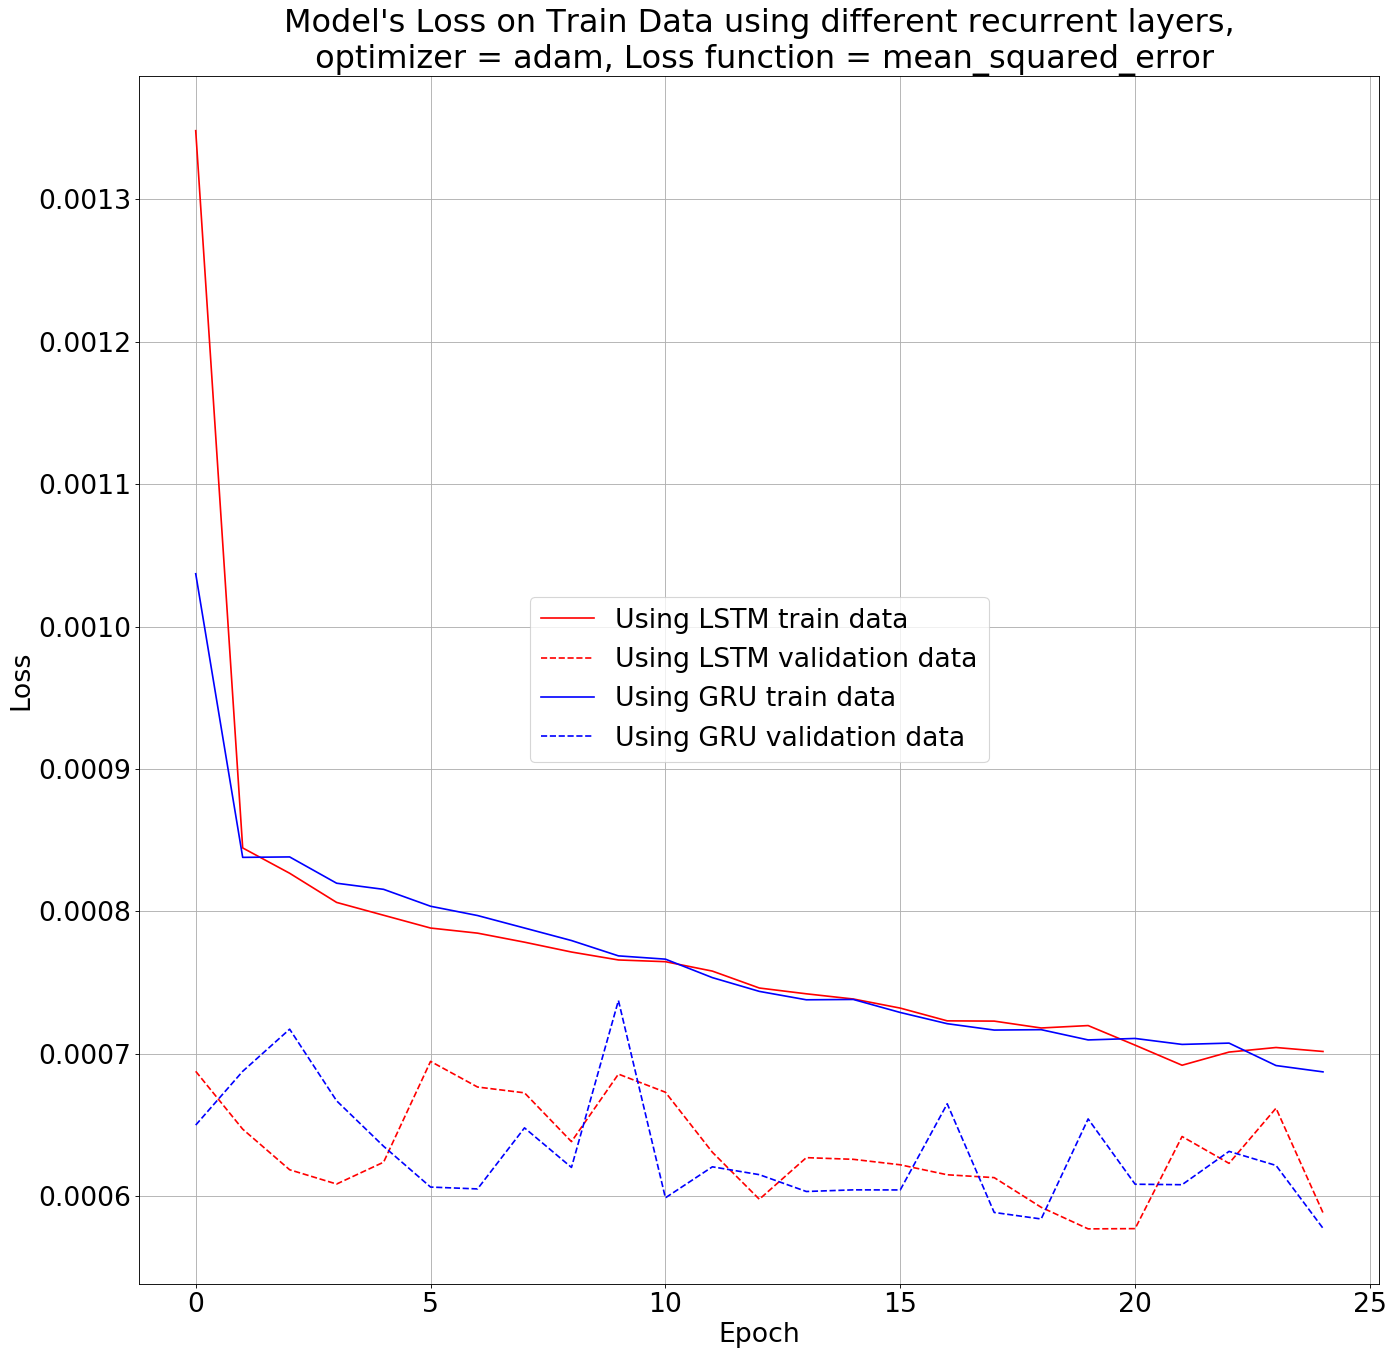

In [185]:
# Plotting Loss values
if drop_use == True:
    DROPUSE = "\nusing DropOut Layers"
else:
    DROPUSE = "without \nusing DropOut Layers"
    
if Recurrent_Layer == 0:
    RECURRENT = "RNN"
elif Recurrent_Layer == 1:
    RECURRENT = "LSTM"
elif Recurrent_Layer == 2:
    RECURRENT = "GRU"
    
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='w')
font = {'weight' : 'normal',
        'size'   : 24}
plt.rc('font', **font)
plt.plot(Results_last[0]['loss'], 'r-', label = 'Using LSTM train data')
plt.plot(Results_last[0]['val_loss'], 'r--', label = 'Using LSTM validation data')
plt.plot(Results_last[1]['loss'], 'b-', label = 'Using GRU train data')
plt.plot(Results_last[1]['val_loss'], 'b--', label = 'Using GRU validation data')
plt.title(f"Model's Loss on Train Data using different recurrent layers,\n optimizer = {Optimizer}, Loss function = {Loss}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid('on')
plt.legend(loc="center")
plt.show()

In [193]:
print("LSTM layer:")
print(f"Time taken = {Time_taken_last[0]} seconds")
print(f"Test evaluation:")
print(f"MSE={Test_evaluation_last[0][0]}, MAE={Test_evaluation_last[0][1]}")
print('\n')


print("GRU layer:")
print(f"Time taken = {Time_taken_last[1]} seconds")
print(f"Test evaluation:")
print(f"MSE={Test_evaluation_last[1][0]}, MAE={Test_evaluation_last[1][1]}")

LSTM layer:
Time taken = 174.55785536766052 seconds
Test evaluation:
MSE=0.0004945827661756014, MAE=0.0004945827531628311


GRU layer:
Time taken = 188.89175987243652 seconds
Test evaluation:
MSE=0.0005121526483447106, MAE=0.0005121525609865785
